In [21]:
import os, sys
import re
import time
from collections import Counter

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

# import torch
# import torchvision
# import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import random

import pandas as pd
import cv2
from tqdm import tqdm

In [22]:
dataset_type = "testing"

options = {
    'crop_size': 256,
    'coverage_pass_thres': 0.1,
    'output_snippet_dir': "/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/" + dataset_type,
    "input_aiskyeye_seq_path_training": "/projectnb/saenkog/awong1/dataset/aiskyeye/VisDrone2019-VID-train/sequences",
    "input_aiskyeye_seq_path_validation": "/projectnb/saenkog/awong1/dataset/aiskyeye/VisDrone2019-VID-val/sequences",
    "input_aiskyeye_seq_path_testing": "/projectnb/saenkog/awong1/dataset/aiskyeye/VisDrone2019-VID-test-dev/sequences",
    "input_aiskyeye_label_path_training": "/projectnb/saenkog/awong1/dataset/aiskyeye/VisDrone2019-VID-train/annotations",
    "input_aiskyeye_label_path_validation": "/projectnb/saenkog/awong1/dataset/aiskyeye/VisDrone2019-VID-val/annotations",
    "input_aiskyeye_label_path_testing": "/projectnb/saenkog/awong1/dataset/aiskyeye/VisDrone2019-VID-test-dev/annotations",
}

input_img_dir = options["input_aiskyeye_seq_path_" + dataset_type]
annotation_dir = options["input_aiskyeye_label_path_" + dataset_type]

print(input_img_dir)
print(annotation_dir)

/projectnb/saenkog/awong1/dataset/aiskyeye/VisDrone2019-VID-test-dev/sequences
/projectnb/saenkog/awong1/dataset/aiskyeye/VisDrone2019-VID-test-dev/annotations


In [23]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install --user bbox

You should consider upgrading via the 'pip install --upgrade pip' command.


/projectnb/saenkog/awong1/dataset/aiskyeye/VisDrone2019-VID-test-dev/sequences/uav0000009_03358_v/0000001.jpg
(765, 1360, 3)


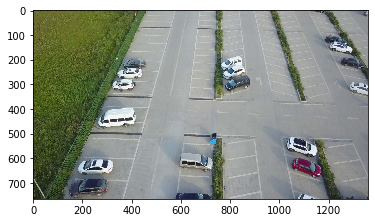

In [24]:
train_seq_dir = input_img_dir

for seq_dirname in sorted(os.listdir(input_img_dir)):
    seq_path = train_seq_dir + "/" + seq_dirname
    for img_name in sorted(os.listdir(seq_path)):
        img_path = seq_path + "/" + img_name
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print(img.shape)
        plt.imshow(img)
        plt.show()
        break
    break

In [25]:
# Read Annotations - generate df_annotation_raw

orig_HEADER = [
    "frame_index",
    "target_id",
    "bbox_left",
    "bbox_top",
    "bbox_width",
    "bbox_height",
    "score",
    "object_category",
    "truncation",
    "occlusion"
]

processed_HEADER = [
    "frame_index",
    "target_id",
    "bbox_left",
    "bbox_top",
    "bbox_width",
    "bbox_height",
    "score",
    "object_category",
    "truncation",
    "occlusion",
    "seq_name"
]

df_annotation_raw = pd.DataFrame(columns=processed_HEADER)

count = 0
print("annotation_dir", annotation_dir)
for annotation_file in sorted(os.listdir(annotation_dir)):
    annotation_path = annotation_dir + "/" + annotation_file
    annotation = pd.read_csv(annotation_path, names=orig_HEADER)
    annotation['seq_name'] = annotation_file[:-4]
    df_annotation_raw = df_annotation_raw.append(annotation, ignore_index=True)
    
#     # TODO: remove
#     if count == 1:
#         break
#     count += 1
    
df_annotation_raw

annotation_dir /projectnb/saenkog/awong1/dataset/aiskyeye/VisDrone2019-VID-test-dev/annotations


,frame_index,target_id,bbox_left,bbox_top,bbox_width,bbox_height,score,object_category,truncation,occlusion,seq_name
0,98,0,808,1,47,22,1,4,0,0,uav0000009_03358_v
1,99,0,808,55,46,21,1,4,0,0,uav0000009_03358_v
2,100,0,806,112,47,23,1,4,0,0,uav0000009_03358_v
3,101,0,802,122,47,22,1,4,0,0,uav0000009_03358_v
4,102,0,800,122,47,22,1,4,0,0,uav0000009_03358_v
...,...,...,...,...,...,...,...,...,...,...,...
333695,1,29,2298,1132,417,291,1,6,1,1,uav0000370_00001_v
333696,2,29,2332,1137,384,290,1,6,1,1,uav0000370_00001_v
333697,3,29,2366,1142,351,290,1,6,1,1,uav0000370_00001_v
333698,4,29,2400,1147,318,290,1,6,1,1,uav0000370_00001_v


In [26]:
# Further process df_annotation_raw -> df_proc_1. (Create columns)

# car (4), van (5), truck (6), tricycle (7), awning-tricycle (8), bus (9), motor (10) --> 'car' category, else 'no_car'

shortlist_HEADER_2 = [
    "frame_index",
    "bbox_left",
    "bbox_top",
    "bbox_width",
    "bbox_height",
    "has_car",
    "seq_name",
    "img_path"
]

has_car_categories = [4,5,6,9] # [4,5,6,7,8,9,10]

# Create has_car category column
object_categories = np.array(df_annotation_raw['object_category'].to_list())
has_car_lst = np.isin(object_categories, has_car_categories).astype(int)
df_annotation_raw['has_car'] = has_car_lst

# df_annotation_raw
# Create img_path column
seq_names = df_annotation_raw['seq_name'].to_list()
frame_indexes = df_annotation_raw['frame_index'].to_list()
img_file_names = ["{:07.0f}.jpg".format(frame) for frame in frame_indexes]

img_paths = []
for i in range(len(seq_names)):
    img_path = input_img_dir + "/" + seq_names[i] + "/" + img_file_names[i]
    img_paths.append(img_path)

    
print(img_path) 

df_annotation_raw['img_path'] = img_paths

# Shortlist header
df_proc_1 = df_annotation_raw[shortlist_HEADER_2]
df_proc_1

/projectnb/saenkog/awong1/dataset/aiskyeye/VisDrone2019-VID-test-dev/sequences/uav0000370_00001_v/0000005.jpg


,frame_index,bbox_left,bbox_top,bbox_width,bbox_height,has_car,seq_name,img_path
0,98,808,1,47,22,1,uav0000009_03358_v,/projectnb/saenkog/awong1/dataset/aiskyeye/Vis...
1,99,808,55,46,21,1,uav0000009_03358_v,/projectnb/saenkog/awong1/dataset/aiskyeye/Vis...
2,100,806,112,47,23,1,uav0000009_03358_v,/projectnb/saenkog/awong1/dataset/aiskyeye/Vis...
3,101,802,122,47,22,1,uav0000009_03358_v,/projectnb/saenkog/awong1/dataset/aiskyeye/Vis...
4,102,800,122,47,22,1,uav0000009_03358_v,/projectnb/saenkog/awong1/dataset/aiskyeye/Vis...
...,...,...,...,...,...,...,...,...
333695,1,2298,1132,417,291,1,uav0000370_00001_v,/projectnb/saenkog/awong1/dataset/aiskyeye/Vis...
333696,2,2332,1137,384,290,1,uav0000370_00001_v,/projectnb/saenkog/awong1/dataset/aiskyeye/Vis...
333697,3,2366,1142,351,290,1,uav0000370_00001_v,/projectnb/saenkog/awong1/dataset/aiskyeye/Vis...
333698,4,2400,1147,318,290,1,uav0000370_00001_v,/projectnb/saenkog/awong1/dataset/aiskyeye/Vis...


In [27]:
# Process df_proc_1 -> image_class_info (Group sequence name and frame id)

def lst_to_comma_sep(lst):
    lst = [str(l) for l in lst]
    return ",".join(lst)

image_class_info = pd.DataFrame(columns=shortlist_HEADER_2)

uniq_seq_names = np.unique(np.array(df_proc_1['seq_name'].to_list()))
# print(uniq_seq_names)

for uniq_seq_name in uniq_seq_names:
    print("uniq_seq_name=", uniq_seq_name)
    df_filt_seq_name = df_proc_1[df_proc_1['seq_name'] == uniq_seq_name]
    uniq_frame_idxs = np.unique(np.array(df_filt_seq_name['frame_index'].to_list()))
    
    for uniq_frame_idx in uniq_frame_idxs:
#         print("Processing sequence({}), frame({})".format(uniq_seq_name, uniq_frame_idx))
        df_filt_seq_name_idx = df_filt_seq_name[df_filt_seq_name['frame_index'] == uniq_frame_idx]
        
        # has_car category
        df_filt_seq_name_idx_has_car = df_filt_seq_name_idx[df_filt_seq_name_idx['has_car'] == 1]
        if len(df_filt_seq_name_idx_has_car) != 0:
            bbox_l_arr = df_filt_seq_name_idx_has_car['bbox_left'].to_list()
            bbox_t_arr = df_filt_seq_name_idx_has_car['bbox_top'].to_list()
            bbox_w_arr = df_filt_seq_name_idx_has_car['bbox_width'].to_list()
            bbox_h_arr = df_filt_seq_name_idx_has_car['bbox_height'].to_list()
            bbox_r_arr = np.ndarray.tolist(np.array(bbox_l_arr) + np.array(bbox_w_arr))
            bbox_b_arr = np.ndarray.tolist(np.array(bbox_t_arr) + np.array(bbox_h_arr))
            
            bbox_l = lst_to_comma_sep(bbox_l_arr)
            bbox_t = lst_to_comma_sep(bbox_t_arr)
            bbox_r = lst_to_comma_sep(bbox_r_arr)
            bbox_b = lst_to_comma_sep(bbox_b_arr)

            has_car = 1
        else:
            bbox_l = ''
            bbox_t = ''
            bbox_r = ''
            bbox_b = ''
            has_car = 0
        data = {
            'frame_index': uniq_frame_idx,
            'bbox_l': bbox_l,
            'bbox_t': bbox_t,
            'bbox_r': bbox_r,
            'bbox_b': bbox_b,
            'has_car': has_car,
            'seq_name': uniq_seq_name,
            'img_path': df_filt_seq_name_idx['img_path'].to_list()[0]
        }
        image_class_info = image_class_info.append(data, ignore_index=True)
#     break

uniq_seq_name= uav0000009_03358_v
uniq_seq_name= uav0000073_00600_v
uniq_seq_name= uav0000073_04464_v
uniq_seq_name= uav0000077_00720_v
uniq_seq_name= uav0000088_00290_v
uniq_seq_name= uav0000119_02301_v
uniq_seq_name= uav0000120_04775_v
uniq_seq_name= uav0000161_00000_v
uniq_seq_name= uav0000188_00000_v
uniq_seq_name= uav0000201_00000_v
uniq_seq_name= uav0000249_00001_v
uniq_seq_name= uav0000249_02688_v
uniq_seq_name= uav0000297_00000_v
uniq_seq_name= uav0000297_02761_v
uniq_seq_name= uav0000306_00230_v
uniq_seq_name= uav0000355_00001_v
uniq_seq_name= uav0000370_00001_v


In [28]:
print(image_class_info[image_class_info['has_car'] == 1])

     frame_index bbox_left bbox_top bbox_width bbox_height has_car  \
0              1       NaN      NaN        NaN         NaN       1   
1              2       NaN      NaN        NaN         NaN       1   
2              3       NaN      NaN        NaN         NaN       1   
3              4       NaN      NaN        NaN         NaN       1   
4              5       NaN      NaN        NaN         NaN       1   
...          ...       ...      ...        ...         ...     ...   
6630         261       NaN      NaN        NaN         NaN       1   
6631         262       NaN      NaN        NaN         NaN       1   
6632         263       NaN      NaN        NaN         NaN       1   
6633         264       NaN      NaN        NaN         NaN       1   
6634         265       NaN      NaN        NaN         NaN       1   

                seq_name                                           img_path  \
0     uav0000009_03358_v  /projectnb/saenkog/awong1/dataset/aiskyeye/Vis...   
1

In [29]:
print("no_car=", len(image_class_info[image_class_info['has_car']==0]))
print("has_car=", len(image_class_info[image_class_info['has_car']==1]))

no_car= 856
has_car= 5779


In [30]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
#     assert bb1['x1'] < bb1['x2']
#     assert bb1['y1'] < bb1['y2']
#     assert bb2['x1'] < bb2['x2']
#     assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    #iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    #assert iou >= 0.0
    #assert iou <= 1.0
    if float(bb2_area) == 0.0:
        return 0.0
    return float(intersection_area)/float(bb2_area)

a1 = {"x1": 400, "x2": 600, "y1": 0, "y2": 200}
a2 = {"x1": 400, "x2": 600, "y1": 0, "y2": 200} #514 573 88 195 #230 261 169 255
get_iou(a1, a2)

# from bbox import BBox2D, XYXY
# from bbox.metrics import jaccard_index_2d

# a1 = BBox2D([400, 0, 624, 224], mode=XYXY)
# a2 = BBox2D([230, 169, 230, 255], mode=XYXY)
# jaccard_index_2d(a1, a2)

1.0

In [31]:
def find_crop_img_bbox_loc(crop_box, obj_box):
    # determine the coordinates of the intersection rectangle
    x_left = max(crop_box['x1'], obj_box['x1'])
    y_top = max(crop_box['y1'], obj_box['y1'])
    x_right = min(crop_box['x2'], obj_box['x2'])
    y_bottom = min(crop_box['y2'], obj_box['y2'])

    if x_right < x_left or y_bottom < y_top:
        return None
    else:
        bbox = ((x_left, y_top), (x_right, y_bottom))
        bbox_with_offset = ((x_left - crop_box['x1'], y_top - crop_box['y1']), (x_right-crop_box['x1'], y_bottom-crop_box['y1']))
        
#         print("crop_box={}, obj_box={}".format(crop_box, obj_box))
#         print("bbox={}, bbox_with_offset={}".format(bbox, bbox_with_offset))
        return bbox_with_offset

In [32]:
has_car_imgs = []
has_car_bbox_imgs = []
has_car_entire_bbox_imgs = []

no_car_imgs = []
no_car_bbox_imgs = []
no_car_entire_bbox_imgs = []

img_crop_bbox_offset_locs_all = []

disp_img = False
skipped = 0

for i, (index, row) in tqdm(enumerate(image_class_info.iterrows())):
#     print("img_path:", row["img_path"])
    img = cv2.imread(row["img_path"], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_bbox = img.copy()
    
    min_val = options['crop_size']
    min_side = min(img.shape[0], img.shape[1])

#     print("min_val:", min_val, ", min_side:", min_side, ", img shape:", img.shape)
    if min_val > min_side:
        continue
        skipped += 1
    crop_idx_x = np.random.randint(0, min_side-min_val)
    crop_idx_y = np.random.randint(0, min_side-min_val)
    img_crop = img[crop_idx_y:crop_idx_y+min_val, crop_idx_x:crop_idx_x+min_val].copy()
    img_crop_bbox = img_crop.copy()
    has_car = False  
    img_crop_bbox_offset_locs = []

    if row["bbox_l"] != "":
        img_crop_bbox2 = img_crop.copy()
        
        for tup in zip(row["bbox_l"].split(","), row["bbox_t"].split(","), row["bbox_r"].split(","), row["bbox_b"].split(",")):
            bbox_l = int(tup[0])
            bbox_t = int(tup[1])
            bbox_r = int(tup[2])
            bbox_b = int(tup[3])

            crop_box = {"x1": crop_idx_x, "x2": crop_idx_x+min_val, "y1": crop_idx_y, "y2": crop_idx_y+min_val}
            obj_box = {"x1": bbox_l, "x2": bbox_r, "y1": bbox_t, "y2": bbox_b}
            coverage = get_iou(crop_box, obj_box)
    #         print("coverage", coverage)

            if coverage > 0.1:
#             if coverage > options['coverage_pass_thres']:
                has_car = True
                img_crop_bbox_offset_locs.append(find_crop_img_bbox_loc(crop_box, obj_box))

            img_bbox = cv2.rectangle(img_bbox, (bbox_l, bbox_t), (bbox_r, bbox_b), (0,255,0), 2)
            
        for img_crop_bbox_offset_loc in img_crop_bbox_offset_locs:
            img_crop_bbox2 = cv2.rectangle(img_crop_bbox2, img_crop_bbox_offset_loc[0], img_crop_bbox_offset_loc[1], (0,225,0), 2)
            
        img_crop_bbox = img_bbox[crop_idx_y:crop_idx_y+min_val, crop_idx_x:crop_idx_x+min_val].copy()
    if disp_img:
        print("has_car?", has_car)
        plt.imshow(img_crop)
        plt.show()
        plt.imshow(img_crop_bbox)
        plt.show()
        print("img_crop_bbox2")
        plt.imshow(img_crop_bbox2)
        plt.show()

        plt.imshow(img_bbox)
        plt.show()

    if has_car:
        has_car_imgs.append(img_crop)
        has_car_bbox_imgs.append(img_crop_bbox)
        has_car_entire_bbox_imgs.append(img_bbox)
        img_crop_bbox_offset_locs_all.append(img_crop_bbox_offset_locs)
    else:
        no_car_imgs.append(img_crop)
        no_car_bbox_imgs.append(img_crop_bbox)
        no_car_entire_bbox_imgs.append(img_bbox)

#     if i > 50: break # TODO: Remove
    if i % 100:
        print(i)
print("Skipped {} images.".format(skipped))

5it [00:00, 22.75it/s]

1
2
3
4
5


11it [00:00, 23.83it/s]

6
7
8
9
10


17it [00:00, 24.14it/s]

11
12
13
14
15
16


20it [00:00, 19.49it/s]

17
18
19


25it [00:01, 21.14it/s]

20
21
22
23
24


28it [00:01, 22.49it/s]

25
26
27
28
29


34it [00:01, 22.54it/s]

30
31
32
33
34
35


40it [00:01, 23.15it/s]

36
37
38
39
40


46it [00:02, 24.57it/s]

41
42
43
44
45
46


52it [00:02, 24.77it/s]

47
48
49
50
51


58it [00:02, 24.93it/s]

52
53
54
55
56
57


64it [00:02, 25.40it/s]

58
59
60
61
62
63


70it [00:02, 26.52it/s]

64
65
66
67
68
69


76it [00:03, 27.23it/s]

70
71
72
73
74
75


82it [00:03, 27.72it/s]

76
77
78
79
80
81


88it [00:03, 28.36it/s]

82
83
84
85
86
87


94it [00:03, 28.02it/s]

88
89
90
91
92
93


100it [00:04, 27.99it/s]

94
95
96
97
98
99


103it [00:04, 25.00it/s]

101
102
103
104


109it [00:04, 24.81it/s]

105
106
107
108
109
110


115it [00:04, 21.40it/s]

111
112
113
114
115
116


121it [00:04, 23.38it/s]

117
118
119
120
121
122


127it [00:05, 24.36it/s]

123
124
125
126
127


133it [00:05, 23.45it/s]

128
129
130
131
132
133


136it [00:05, 24.12it/s]

134
135
136


139it [00:05, 16.63it/s]

137
138
139
140


145it [00:06, 19.26it/s]

141
142
143
144
145
146


148it [00:06, 21.06it/s]

147
148
149


153it [00:06, 15.44it/s]

150
151
152
153


156it [00:06, 17.33it/s]

154
155
156


158it [00:07, 14.43it/s]

157


160it [00:07, 11.08it/s]

158
159
160


165it [00:07, 13.81it/s]

161
162
163
164
165


170it [00:07, 16.74it/s]

166
167
168
169
170
171


176it [00:08, 20.70it/s]

172
173
174
175
176
177


182it [00:08, 23.39it/s]

178
179
180
181
182
183


188it [00:08, 24.97it/s]

184
185
186
187
188
189


194it [00:08, 25.88it/s]

190
191
192
193
194
195


200it [00:08, 26.38it/s]

196
197
198
199
201


206it [00:09, 26.77it/s]

202
203
204
205
206
207


212it [00:09, 27.02it/s]

208
209
210
211
212
213


215it [00:09, 27.25it/s]

214
215
216


218it [00:09, 20.67it/s]

217
218
219


221it [00:09, 17.13it/s]

220
221


225it [00:10, 14.40it/s]

222
223
224
225


227it [00:10, 15.03it/s]

226
227


231it [00:10, 10.71it/s]

228
229
230


235it [00:11, 13.10it/s]

231
232
233
234


237it [00:11, 14.03it/s]

235
236
237


241it [00:11, 12.89it/s]

238
239
240


245it [00:11, 14.62it/s]

241
242
243
244


249it [00:12, 15.64it/s]

245
246
247
248


253it [00:12, 16.15it/s]

249
250
251
252


255it [00:12, 16.23it/s]

253
254


257it [00:12, 12.34it/s]

255
256
257


261it [00:13, 12.40it/s]

258
259
260


265it [00:13, 13.94it/s]

261
262
263
264


269it [00:13, 14.86it/s]

265
266
267
268


273it [00:13, 15.36it/s]

269
270
271
272


277it [00:14, 15.57it/s]

273
274
275
276


281it [00:14, 15.70it/s]

277
278
279
280


285it [00:14, 15.72it/s]

281
282
283
284


289it [00:14, 15.82it/s]

285
286
287
288


293it [00:15, 15.82it/s]

289
290
291
292


297it [00:15, 15.79it/s]

293
294
295
296


301it [00:15, 15.89it/s]

297
298
299


303it [00:15, 13.78it/s]

301
302
303


307it [00:16, 13.46it/s]

304
305
306
307


311it [00:16, 14.01it/s]

308
309
310
311


315it [00:16, 13.10it/s]

312
313
314


319it [00:16, 13.89it/s]

315
316
317
318


323it [00:17, 12.11it/s]

319
320
321
322


325it [00:17,  9.13it/s]

323
324


327it [00:17,  9.54it/s]

325
326
327


329it [00:18, 10.29it/s]

328
329


331it [00:18,  9.28it/s]

330
331


334it [00:18,  8.58it/s]

332
333
334


338it [00:18, 10.58it/s]

335
336
337
338


342it [00:19, 13.02it/s]

339
340
341
342


344it [00:19, 13.93it/s]

343
344


348it [00:19, 12.48it/s]

345
346
347


352it [00:20, 13.33it/s]

348
349
350
351


356it [00:20, 14.60it/s]

352
353
354
355


360it [00:20, 15.54it/s]

356
357
358
359


364it [00:20, 15.81it/s]

360
361
362
363


368it [00:20, 16.21it/s]

364
365
366
367


372it [00:21, 16.42it/s]

368
369
370
371


376it [00:21, 16.40it/s]

372
373
374
375


380it [00:21, 16.27it/s]

376
377
378
379


384it [00:21, 16.52it/s]

380
381
382
383


388it [00:22, 16.81it/s]

384
385
386
387


392it [00:22, 16.77it/s]

388
389
390
391


396it [00:22, 16.65it/s]

392
393
394
395


400it [00:22, 16.49it/s]

396
397
398
399


404it [00:23, 16.34it/s]

401
402
403
404


408it [00:23, 16.23it/s]

405
406
407
408


412it [00:23, 16.16it/s]

409
410
411
412


416it [00:23, 16.16it/s]

413
414
415
416


420it [00:24, 16.08it/s]

417
418
419
420


424it [00:24, 16.08it/s]

421
422
423
424


428it [00:24, 16.03it/s]

425
426
427
428


432it [00:24, 16.05it/s]

429
430
431
432


436it [00:25, 16.00it/s]

433
434
435
436


440it [00:25, 15.97it/s]

437
438
439
440


444it [00:25, 15.95it/s]

441
442
443
444


448it [00:25, 15.95it/s]

445
446
447
448


452it [00:26, 15.98it/s]

449
450
451
452


456it [00:26, 15.99it/s]

453
454
455
456


460it [00:26, 16.04it/s]

457
458
459
460


464it [00:26, 16.06it/s]

461
462
463
464


468it [00:27, 16.12it/s]

465
466
467
468


472it [00:27, 16.15it/s]

469
470
471
472


476it [00:27, 16.17it/s]

473
474
475
476


480it [00:27, 16.17it/s]

477
478
479
480


484it [00:28, 16.19it/s]

481
482
483
484


488it [00:28, 16.17it/s]

485
486
487
488


492it [00:28, 16.17it/s]

489
490
491
492


496it [00:28, 16.16it/s]

493
494
495
496


500it [00:29, 16.16it/s]

497
498
499


504it [00:29, 16.16it/s]

501
502
503
504


508it [00:29, 16.19it/s]

505
506
507
508


512it [00:29, 16.20it/s]

509
510
511
512


516it [00:30, 16.23it/s]

513
514
515
516


520it [00:30, 16.23it/s]

517
518
519
520


524it [00:30, 16.20it/s]

521
522
523
524


528it [00:30, 16.20it/s]

525
526
527
528


532it [00:31, 16.22it/s]

529
530
531
532


536it [00:31, 16.23it/s]

533
534
535
536


540it [00:31, 16.24it/s]

537
538
539
540


544it [00:31, 16.25it/s]

541
542
543
544


548it [00:32, 16.07it/s]

545
546
547
548


552it [00:32, 15.73it/s]

549
550
551
552


556it [00:32, 15.73it/s]

553
554
555
556


560it [00:32, 15.70it/s]

557
558
559
560


564it [00:33, 15.69it/s]

561
562
563
564


568it [00:33, 15.61it/s]

565
566
567
568


572it [00:33, 15.52it/s]

569
570
571
572


576it [00:33, 15.47it/s]

573
574
575
576


580it [00:34, 15.37it/s]

577
578
579
580


584it [00:34, 15.34it/s]

581
582
583
584


588it [00:34, 15.26it/s]

585
586
587
588


592it [00:34, 15.19it/s]

589
590
591
592


596it [00:35, 15.23it/s]

593
594
595
596


600it [00:35, 15.19it/s]

597
598
599


604it [00:35, 15.23it/s]

601
602
603
604


608it [00:36, 15.31it/s]

605
606
607
608


612it [00:36, 15.36it/s]

609
610
611
612


616it [00:36, 15.43it/s]

613
614
615
616


620it [00:36, 15.50it/s]

617
618
619
620


624it [00:37, 15.61it/s]

621
622
623
624


628it [00:37, 15.65it/s]

625
626
627
628


632it [00:37, 15.70it/s]

629
630
631
632


636it [00:37, 15.74it/s]

633
634
635
636


640it [00:38, 15.77it/s]

637
638
639
640


644it [00:38, 15.78it/s]

641
642
643
644


648it [00:38, 15.77it/s]

645
646
647
648


652it [00:38, 15.83it/s]

649
650
651
652


656it [00:39, 15.80it/s]

653
654
655
656


660it [00:39, 15.74it/s]

657
658
659
660


664it [00:39, 15.68it/s]

661
662
663
664


668it [00:39, 15.73it/s]

665
666
667
668


672it [00:40, 15.83it/s]

669
670
671
672


676it [00:40, 15.73it/s]

673
674
675
676


680it [00:40, 15.63it/s]

677
678
679
680


684it [00:40, 15.62it/s]

681
682
683
684


688it [00:41, 15.59it/s]

685
686
687
688


692it [00:41, 15.57it/s]

689
690
691
692


696it [00:41, 15.55it/s]

693
694
695
696


700it [00:41, 15.56it/s]

697
698
699


704it [00:42, 15.57it/s]

701
702
703
704


708it [00:42, 15.56it/s]

705
706
707
708


712it [00:42, 15.55it/s]

709
710
711
712


716it [00:42, 15.56it/s]

713
714
715
716


720it [00:43, 15.51it/s]

717
718
719
720


724it [00:43, 15.50it/s]

721
722
723
724


728it [00:43, 15.54it/s]

725
726
727
728


732it [00:43, 15.57it/s]

729
730
731
732


736it [00:44, 15.56it/s]

733
734
735
736


740it [00:44, 15.51it/s]

737
738
739
740


744it [00:44, 15.49it/s]

741
742
743
744


748it [00:44, 15.53it/s]

745
746
747
748


752it [00:45, 15.49it/s]

749
750
751
752


756it [00:45, 15.47it/s]

753
754
755
756


760it [00:45, 15.50it/s]

757
758
759
760


764it [00:46, 15.51it/s]

761
762
763
764


768it [00:46, 15.58it/s]

765
766
767
768


772it [00:46, 15.55it/s]

769
770
771
772


776it [00:46, 15.57it/s]

773
774
775
776


780it [00:47, 15.58it/s]

777
778
779
780


784it [00:47, 15.49it/s]

781
782
783
784


788it [00:47, 15.53it/s]

785
786
787
788


792it [00:47, 15.58it/s]

789
790
791
792


796it [00:48, 15.54it/s]

793
794
795
796


800it [00:48, 15.57it/s]

797
798
799


804it [00:48, 15.65it/s]

801
802
803
804


808it [00:48, 15.65it/s]

805
806
807
808


812it [00:49, 15.66it/s]

809
810
811
812


816it [00:49, 15.67it/s]

813
814
815
816


820it [00:49, 15.64it/s]

817
818
819
820


824it [00:49, 15.63it/s]

821
822
823
824


828it [00:50, 15.62it/s]

825
826
827
828


832it [00:50, 15.65it/s]

829
830
831
832


836it [00:50, 15.67it/s]

833
834
835
836


840it [00:50, 15.61it/s]

837
838
839
840


844it [00:51, 15.64it/s]

841
842
843
844


848it [00:51, 15.62it/s]

845
846
847
848


852it [00:51, 15.58it/s]

849
850
851
852


856it [00:51, 15.58it/s]

853
854
855
856


860it [00:52, 16.47it/s]

857
858
859
860
861


866it [00:52, 20.51it/s]

862
863
864
865
866
867


872it [00:52, 23.05it/s]

868
869
870
871
872
873


878it [00:52, 24.73it/s]

874
875
876
877
878
879


884it [00:53, 25.61it/s]

880
881
882
883
884
885


890it [00:53, 25.97it/s]

886
887
888
889
890
891


896it [00:53, 26.21it/s]

892
893
894
895
896
897


902it [00:53, 26.14it/s]

898
899
901
902
903


908it [00:53, 26.22it/s]

904
905
906
907
908
909


914it [00:54, 26.31it/s]

910
911
912
913
914
915


920it [00:54, 26.35it/s]

916
917
918
919
920
921


926it [00:54, 26.50it/s]

922
923
924
925
926
927


932it [00:54, 26.57it/s]

928
929
930
931
932
933


938it [00:55, 26.57it/s]

934
935
936
937
938
939


944it [00:55, 27.36it/s]

940
941
942
943
944
945


950it [00:55, 28.05it/s]

946
947
948
949
950
951


956it [00:55, 27.15it/s]

952
953
954
955
956
957


962it [00:55, 26.75it/s]

958
959
960
961
962
963


968it [00:56, 26.49it/s]

964
965
966
967
968
969


974it [00:56, 26.25it/s]

970
971
972
973
974
975


980it [00:56, 26.04it/s]

976
977
978
979
980
981


986it [00:56, 26.04it/s]

982
983
984
985
986
987


992it [00:57, 26.03it/s]

988
989
990
991
992
993


998it [00:57, 25.90it/s]

994
995
996
997
998
999


1007it [00:57, 27.11it/s]

1001
1002
1003
1004
1005
1006


1014it [00:57, 28.47it/s]

1007
1008
1009
1010
1011
1012
1013


1020it [00:58, 28.78it/s]

1014
1015
1016
1017
1018
1019


1026it [00:58, 28.79it/s]

1020
1021
1022
1023
1024
1025


1032it [00:58, 28.85it/s]

1026
1027
1028
1029
1030
1031


1038it [00:58, 27.28it/s]

1032
1033
1034
1035
1036
1037


1044it [00:58, 27.88it/s]

1038
1039
1040
1041
1042
1043


1050it [00:59, 28.24it/s]

1044
1045
1046
1047
1048
1049


1056it [00:59, 28.27it/s]

1050
1051
1052
1053
1054
1055


1062it [00:59, 28.37it/s]

1056
1057
1058
1059
1060
1061


1068it [00:59, 28.46it/s]

1062
1063
1064
1065
1066
1067


1074it [01:00, 28.23it/s]

1068
1069
1070
1071
1072
1073


1080it [01:00, 27.69it/s]

1074
1075
1076
1077
1078
1079


1086it [01:00, 27.44it/s]

1080
1081
1082
1083
1084
1085


1092it [01:00, 27.34it/s]

1086
1087
1088
1089
1090
1091


1098it [01:00, 27.39it/s]

1092
1093
1094
1095
1096
1097


1104it [01:01, 27.63it/s]

1098
1099
1101
1102
1103


1110it [01:01, 27.74it/s]

1104
1105
1106
1107
1108
1109


1116it [01:01, 27.94it/s]

1110
1111
1112
1113
1114
1115


1122it [01:01, 27.77it/s]

1116
1117
1118
1119
1120
1121


1128it [01:01, 27.64it/s]

1122
1123
1124
1125
1126
1127


1134it [01:02, 27.58it/s]

1128
1129
1130
1131
1132
1133


1140it [01:02, 27.54it/s]

1134
1135
1136
1137
1138
1139


1146it [01:02, 27.43it/s]

1140
1141
1142
1143
1144
1145


1152it [01:02, 27.30it/s]

1146
1147
1148
1149
1150
1151


1158it [01:03, 27.23it/s]

1152
1153
1154
1155
1156
1157


1164it [01:03, 27.16it/s]

1158
1159
1160
1161
1162
1163


1170it [01:03, 27.13it/s]

1164
1165
1166
1167
1168
1169


1176it [01:03, 27.14it/s]

1170
1171
1172
1173
1174
1175


1182it [01:03, 27.28it/s]

1176
1177
1178
1179
1180
1181


1188it [01:04, 27.21it/s]

1182
1183
1184
1185
1186
1187


1194it [01:04, 27.00it/s]

1188
1189
1190
1191
1192
1193


1200it [01:04, 26.78it/s]

1194
1195
1196
1197
1198
1199


1206it [01:04, 26.67it/s]

1201
1202
1203
1204
1205
1206


1212it [01:05, 26.92it/s]

1207
1208
1209
1210
1211
1212


1219it [01:05, 27.93it/s]

1213
1214
1215
1216
1217
1218


1225it [01:05, 27.32it/s]

1219
1220
1221
1222
1223
1224


1231it [01:05, 27.13it/s]

1225
1226
1227
1228
1229
1230


1237it [01:05, 27.06it/s]

1231
1232
1233
1234
1235
1236


1243it [01:06, 26.77it/s]

1237
1238
1239
1240
1241
1242


1249it [01:06, 26.81it/s]

1243
1244
1245
1246
1247
1248


1255it [01:06, 26.73it/s]

1249
1250
1251
1252
1253
1254


1261it [01:06, 26.65it/s]

1255
1256
1257
1258
1259
1260


1267it [01:07, 26.44it/s]

1261
1262
1263
1264
1265
1266


1273it [01:07, 26.07it/s]

1267
1268
1269
1270
1271
1272


1279it [01:07, 25.94it/s]

1273
1274
1275
1276
1277
1278


1285it [01:07, 25.80it/s]

1279
1280
1281
1282
1283
1284


1291it [01:08, 26.92it/s]

1285
1286
1287
1288
1289
1290


1295it [01:08, 28.02it/s]

1291
1292
1293
1294
1295
1296
1297


1302it [01:08, 28.89it/s]

1298
1299
1301
1302
1303


1308it [01:08, 27.85it/s]

1304
1305
1306
1307
1308
1309


1314it [01:08, 26.91it/s]

1310
1311
1312
1313
1314
1315


1320it [01:09, 28.02it/s]

1316
1317
1318
1319
1320
1321


1326it [01:09, 28.11it/s]

1322
1323
1324
1325
1326
1327


1332it [01:09, 28.36it/s]

1328
1329
1330
1331
1332
1333


1335it [01:09, 21.23it/s]

1334
1335


1338it [01:09, 16.29it/s]

1336
1337
1338


1340it [01:10, 13.24it/s]

1339
1340


1342it [01:10,  9.52it/s]

1341
1342


1347it [01:10, 11.19it/s]

1343
1344
1345
1346
1347
1348


1353it [01:11, 16.32it/s]

1349
1350
1351
1352
1353
1354


1359it [01:11, 20.50it/s]

1355
1356
1357
1358
1359


1362it [01:11, 19.57it/s]

1360
1361
1362
1363


1368it [01:11, 20.53it/s]

1364
1365
1366
1367
1368
1369


1374it [01:11, 23.98it/s]

1370
1371
1372
1373
1374
1375


1380it [01:12, 25.99it/s]

1376
1377
1378
1379
1380
1381


1386it [01:12, 27.28it/s]

1382
1383
1384
1385
1386


1392it [01:12, 25.67it/s]

1387
1388
1389
1390
1391
1392


1398it [01:12, 26.97it/s]

1393
1394
1395
1396
1397
1398


1404it [01:13, 27.90it/s]

1399
1401
1402
1403
1404


1410it [01:13, 28.58it/s]

1405
1406
1407
1408
1409
1410


1416it [01:13, 29.07it/s]

1411
1412
1413
1414
1415
1416


1422it [01:13, 28.67it/s]

1417
1418
1419
1420
1421
1422


1425it [01:13, 28.89it/s]

1423
1424
1425


1428it [01:14, 16.91it/s]

1426
1427
1428


1431it [01:14, 15.29it/s]

1429
1430


1433it [01:14, 12.99it/s]

1431
1432


1435it [01:14, 10.22it/s]

1433
1434


1437it [01:15,  9.77it/s]

1435
1436
1437


1441it [01:15, 11.20it/s]

1438
1439
1440


1443it [01:15,  9.87it/s]

1441
1442
1443


1448it [01:15, 12.92it/s]

1444
1445
1446
1447
1448
1449


1454it [01:16, 18.17it/s]

1450
1451
1452
1453
1454
1455


1460it [01:16, 22.62it/s]

1456
1457
1458
1459
1460
1461
1462


1468it [01:16, 25.97it/s]

1463
1464
1465
1466
1467
1468


1475it [01:16, 25.56it/s]

1469
1470
1471
1472
1473
1474


1481it [01:17, 26.53it/s]

1475
1476
1477
1478
1479
1480
1481


1484it [01:17, 12.51it/s]

1482
1483
1484


1489it [01:18, 13.84it/s]

1485
1486
1487
1488
1489


1495it [01:18, 17.86it/s]

1490
1491
1492
1493
1494
1495
1496


1503it [01:18, 22.57it/s]

1497
1498
1499
1501
1502
1503


1511it [01:18, 25.96it/s]

1504
1505
1506
1507
1508
1509
1510
1511
1512


1514it [01:19, 17.49it/s]

1513
1514
1515


1517it [01:20,  7.37it/s]

1516
1517


1519it [01:20,  5.07it/s]

1518
1519


1521it [01:21,  4.26it/s]

1520


1523it [01:21,  4.98it/s]

1521
1522


1524it [01:22,  3.90it/s]

1523


1525it [01:22,  3.30it/s]

1524


1526it [01:22,  3.60it/s]

1525


1528it [01:23,  4.14it/s]

1526
1527


1529it [01:23,  3.68it/s]

1528


1530it [01:24,  2.65it/s]

1529


1531it [01:24,  2.75it/s]

1530


1532it [01:25,  2.24it/s]

1531
1532


1534it [01:25,  2.67it/s]

1533


1535it [01:26,  2.46it/s]

1534


1536it [01:26,  2.36it/s]

1535


1537it [01:27,  1.54it/s]

1536


1538it [01:27,  1.81it/s]

1537


1541it [01:28,  2.78it/s]

1538
1539
1540


1542it [01:28,  3.36it/s]

1541


1543it [01:28,  3.32it/s]

1542


1545it [01:29,  2.84it/s]

1543
1544
1545


1547it [01:30,  3.40it/s]

1546
1547


1552it [01:30,  5.18it/s]

1548
1549
1550
1551
1552
1553
1554


1560it [01:30,  8.99it/s]

1555
1556
1557
1558
1559
1560
1561


1568it [01:31, 14.02it/s]

1562
1563
1564
1565
1566
1567
1568


1575it [01:31, 19.35it/s]

1569
1570
1571
1572
1573
1574
1575


1583it [01:31, 25.07it/s]

1576
1577
1578
1579
1580
1581
1582
1583


1591it [01:31, 28.06it/s]

1584
1585
1586
1587
1588
1589
1590


1595it [01:31, 28.90it/s]

1591
1592
1593
1594
1595
1596
1597


1603it [01:32, 30.04it/s]

1598
1599
1601
1602
1603
1604


1607it [01:32, 29.83it/s]

1605
1606
1607
1608


1611it [01:32, 23.74it/s]

1609
1610
1611
1612


1617it [01:32, 19.48it/s]

1613
1614
1615
1616


1620it [01:33, 19.79it/s]

1617
1618
1619
1620


1625it [01:33, 18.35it/s]

1621
1622
1623
1624


1631it [01:33, 20.88it/s]

1625
1626
1627
1628
1629
1630


1635it [01:33, 23.43it/s]

1631
1632
1633
1634
1635
1636
1637


1645it [01:34, 30.50it/s]

1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649


1657it [01:34, 39.73it/s]

1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661


1669it [01:34, 47.10it/s]

1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673


1681it [01:34, 51.78it/s]

1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685


1693it [01:34, 54.50it/s]

1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697


1705it [01:35, 56.04it/s]

1698
1699
1701
1702
1703
1704
1705
1706
1707
1708
1709


1717it [01:35, 56.98it/s]

1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721


1729it [01:35, 56.99it/s]

1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733


1741it [01:35, 56.64it/s]

1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745


1753it [01:35, 56.19it/s]

1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757


1765it [01:36, 56.22it/s]

1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769


1777it [01:36, 56.21it/s]

1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781


1789it [01:36, 56.00it/s]

1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793


1801it [01:36, 55.48it/s]

1794
1795
1796
1797
1798
1799
1801
1802
1803
1804
1805


1813it [01:36, 55.22it/s]

1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817


1825it [01:37, 54.85it/s]

1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828


1837it [01:37, 55.19it/s]

1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840


1849it [01:37, 55.67it/s]

1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852


1861it [01:37, 55.90it/s]

1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863


1873it [01:38, 54.18it/s]

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875


1885it [01:38, 51.61it/s]

1876
1877
1878
1879
1880
1881
1882
1883
1884
1885


1897it [01:38, 54.53it/s]

1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897


1909it [01:38, 55.77it/s]

1898
1899
1901
1902
1903
1904
1905
1906
1907
1908
1909


1921it [01:38, 56.57it/s]

1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921


1933it [01:39, 57.15it/s]

1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933


1939it [01:39, 48.46it/s]

1934
1935
1936
1937
1938
1939
1940


1945it [01:39, 41.29it/s]

1941
1942
1943
1944
1945
1946


1950it [01:39, 36.85it/s]

1947
1948
1949
1950
1951
1952
1953


1959it [01:39, 33.32it/s]

1954
1955
1956
1957
1958
1959
1960


1967it [01:40, 31.76it/s]

1961
1962
1963
1964
1965
1966
1967


1975it [01:40, 31.05it/s]

1968
1969
1970
1971
1972
1973
1974


1979it [01:40, 30.80it/s]

1975
1976
1977
1978
1979
1980
1981


1987it [01:40, 30.65it/s]

1982
1983
1984
1985
1986


1991it [01:41, 24.20it/s]

1987
1988
1989
1990
1991


1998it [01:41, 26.80it/s]

1992
1993
1994
1995
1996
1997
1998


2006it [01:41, 28.72it/s]

1999
2001
2002
2003
2004
2005


2010it [01:41, 29.29it/s]

2006
2007
2008
2009
2010
2011
2012


2018it [01:42, 30.13it/s]

2013
2014
2015
2016
2017
2018
2019


2026it [01:42, 30.44it/s]

2020
2021
2022
2023
2024
2025
2026


2034it [01:42, 30.66it/s]

2027
2028
2029
2030
2031
2032
2033


2038it [01:42, 30.61it/s]

2034
2035
2036
2037
2038
2039
2040


2046it [01:42, 30.69it/s]

2041
2042
2043
2044
2045
2046
2047


2054it [01:43, 30.75it/s]

2048
2049
2050
2051
2052
2053
2054


2062it [01:43, 30.83it/s]

2055
2056
2057
2058
2059
2060
2061


2066it [01:43, 30.76it/s]

2062
2063
2064
2065
2066
2067
2068


2074it [01:43, 30.23it/s]

2069
2070
2071
2072
2073
2074


2081it [01:44, 29.59it/s]

2075
2076
2077
2078
2079
2080


2087it [01:44, 29.44it/s]

2081
2082
2083
2084
2085
2086


2093it [01:44, 28.68it/s]

2087
2088
2089
2090
2091
2092


2099it [01:44, 28.39it/s]

2093
2094
2095
2096
2097
2098


2105it [01:44, 28.83it/s]

2099
2101
2102
2103
2104


2109it [01:45, 29.27it/s]

2105
2106
2107
2108
2109
2110
2111


2117it [01:45, 30.49it/s]

2112
2113
2114
2115
2116
2117
2118


2125it [01:45, 33.31it/s]

2119
2120
2121
2122
2123
2124
2125
2126


2133it [01:45, 33.95it/s]

2127
2128
2129
2130
2131
2132
2133


2141it [01:46, 34.22it/s]

2134
2135
2136
2137
2138
2139
2140


2145it [01:46, 34.31it/s]

2141
2142
2143
2144
2145
2146
2147


2153it [01:46, 34.39it/s]

2148
2149
2150
2151
2152
2153
2154


2161it [01:46, 34.61it/s]

2155
2156
2157
2158
2159
2160
2161


2169it [01:46, 34.69it/s]

2162
2163
2164
2165
2166
2167
2168


2173it [01:46, 34.70it/s]

2169
2170
2171
2172
2173
2174
2175
2176


2185it [01:47, 34.86it/s]

2177
2178
2179
2180
2181
2182
2183
2184


2189it [01:47, 34.86it/s]

2185
2186
2187
2188
2189
2190
2191


2197it [01:47, 34.13it/s]

2192
2193
2194
2195
2196
2197
2198


2205it [01:47, 34.31it/s]

2199
2201
2202
2203
2204
2205


2213it [01:48, 34.44it/s]

2206
2207
2208
2209
2210
2211
2212


2217it [01:48, 34.35it/s]

2213
2214
2215
2216
2217
2218
2219


2225it [01:48, 34.26it/s]

2220
2221
2222
2223
2224
2225
2226


2233it [01:48, 34.45it/s]

2227
2228
2229
2230
2231
2232
2233


2241it [01:48, 35.05it/s]

2234
2235
2236
2237
2238
2239
2240
2241


2249it [01:49, 35.33it/s]

2242
2243
2244
2245
2246
2247
2248
2249


2257it [01:49, 35.22it/s]

2250
2251
2252
2253
2254
2255
2256
2257


2265it [01:49, 35.35it/s]

2258
2259
2260
2261
2262
2263
2264
2265


2273it [01:49, 35.31it/s]

2266
2267
2268
2269
2270
2271
2272
2273


2281it [01:50, 35.34it/s]

2274
2275
2276
2277
2278
2279
2280
2281


2289it [01:50, 35.74it/s]

2282
2283
2284
2285
2286
2287
2288
2289


2297it [01:50, 36.37it/s]

2290
2291
2292
2293
2294
2295
2296
2297


2305it [01:50, 36.64it/s]

2298
2299
2301
2302
2303
2304
2305


2313it [01:50, 36.13it/s]

2306
2307
2308
2309
2310
2311
2312
2313


2321it [01:51, 35.86it/s]

2314
2315
2316
2317
2318
2319
2320
2321


2329it [01:51, 35.71it/s]

2322
2323
2324
2325
2326
2327
2328
2329


2337it [01:51, 35.07it/s]

2330
2331
2332
2333
2334
2335
2336


2345it [01:51, 35.42it/s]

2337
2338
2339
2340
2341
2342
2343
2344


2349it [01:51, 35.25it/s]

2345
2346
2347
2348
2349
2350
2351


2357it [01:52, 34.99it/s]

2352
2353
2354
2355
2356
2357
2358
2359


2365it [01:52, 35.81it/s]

2360
2361
2362
2363
2364
2365
2366
2367


2373it [01:52, 36.01it/s]

2368
2369
2370
2371
2372
2373
2374
2375


2381it [01:52, 36.09it/s]

2376
2377
2378
2379
2380
2381
2382
2383


2390it [01:53, 37.37it/s]

2384
2385
2386
2387
2388
2389
2390
2391


2398it [01:53, 36.16it/s]

2392
2393
2394
2395
2396
2397
2398
2399


2406it [01:53, 35.08it/s]

2401
2402
2403
2404
2405
2406
2407


2414it [01:53, 34.69it/s]

2408
2409
2410
2411
2412
2413
2414


2422it [01:53, 34.84it/s]

2415
2416
2417
2418
2419
2420
2421
2422


2430it [01:54, 35.32it/s]

2423
2424
2425
2426
2427
2428
2429


2434it [01:54, 28.87it/s]

2430
2431
2432
2433


2438it [01:54, 23.81it/s]

2434
2435
2436
2437


2446it [01:54, 29.05it/s]

2438
2439
2440
2441
2442
2443
2444
2445


2454it [01:55, 32.35it/s]

2446
2447
2448
2449
2450
2451
2452
2453


2462it [01:55, 34.63it/s]

2454
2455
2456
2457
2458
2459
2460
2461


2470it [01:55, 35.18it/s]

2462
2463
2464
2465
2466
2467
2468
2469


2478it [01:55, 36.17it/s]

2470
2471
2472
2473
2474
2475
2476
2477


2486it [01:55, 36.31it/s]

2478
2479
2480
2481
2482
2483
2484
2485


2490it [01:56, 35.89it/s]

2486
2487
2488
2489
2490
2491
2492


2498it [01:56, 34.60it/s]

2493
2494
2495
2496
2497
2498
2499


2506it [01:56, 33.99it/s]

2501
2502
2503
2504
2505
2506
2507


2514it [01:56, 34.57it/s]

2508
2509
2510
2511
2512
2513
2514
2515


2522it [01:56, 34.88it/s]

2516
2517
2518
2519
2520
2521
2522
2523


2530it [01:57, 34.60it/s]

2524
2525
2526
2527
2528
2529
2530


2538it [01:57, 34.85it/s]

2531
2532
2533
2534
2535
2536
2537
2538


2546it [01:57, 35.35it/s]

2539
2540
2541
2542
2543
2544
2545
2546


2554it [01:57, 35.70it/s]

2547
2548
2549
2550
2551
2552
2553
2554


2562it [01:58, 35.12it/s]

2555
2556
2557
2558
2559
2560
2561


2566it [01:58, 35.16it/s]

2562
2563
2564
2565
2566
2567
2568


2574it [01:58, 34.28it/s]

2569
2570
2571
2572
2573
2574
2575


2582it [01:58, 33.84it/s]

2576
2577
2578
2579
2580
2581
2582


2590it [01:58, 33.38it/s]

2583
2584
2585
2586
2587
2588
2589


2594it [01:59, 33.36it/s]

2590
2591
2592
2593
2594
2595
2596


2602it [01:59, 33.51it/s]

2597
2598
2599
2601
2602
2603


2610it [01:59, 33.72it/s]

2604
2605
2606
2607
2608
2609
2610


2618it [01:59, 33.84it/s]

2611
2612
2613
2614
2615
2616
2617


2622it [01:59, 33.95it/s]

2618
2619
2620
2621
2622
2623
2624


2630it [02:00, 33.67it/s]

2625
2626
2627
2628
2629
2630
2631


2638it [02:00, 33.38it/s]

2632
2633
2634
2635
2636
2637
2638


2646it [02:00, 33.73it/s]

2639
2640
2641
2642
2643
2644
2645


2650it [02:00, 33.18it/s]

2646
2647
2648
2649
2650
2651
2652


2658it [02:01, 32.41it/s]

2653
2654
2655
2656
2657
2658
2659


2666it [02:01, 32.18it/s]

2660
2661
2662
2663
2664
2665
2666


2674it [02:01, 32.17it/s]

2667
2668
2669
2670
2671
2672
2673


2678it [02:01, 32.10it/s]

2674
2675
2676
2677
2678
2679
2680


2686it [02:01, 32.10it/s]

2681
2682
2683
2684
2685
2686
2687


2694it [02:02, 32.32it/s]

2688
2689
2690
2691
2692
2693
2694


2702it [02:02, 32.42it/s]

2695
2696
2697
2698
2699
2701


2706it [02:02, 32.35it/s]

2702
2703
2704
2705
2706
2707
2708


2714it [02:02, 32.21it/s]

2709
2710
2711
2712
2713
2714
2715


2722it [02:02, 32.19it/s]

2716
2717
2718
2719
2720
2721
2722


2730it [02:03, 32.08it/s]

2723
2724
2725
2726
2727
2728
2729


2734it [02:03, 32.18it/s]

2730
2731
2732
2733
2734
2735
2736


2742it [02:03, 32.30it/s]

2737
2738
2739
2740
2741
2742
2743


2750it [02:03, 32.50it/s]

2744
2745
2746
2747
2748
2749
2750


2758it [02:04, 32.63it/s]

2751
2752
2753
2754
2755
2756
2757


2762it [02:04, 32.48it/s]

2758
2759
2760
2761
2762
2763
2764


2770it [02:04, 32.71it/s]

2765
2766
2767
2768
2769
2770
2771


2778it [02:04, 32.86it/s]

2772
2773
2774
2775
2776
2777
2778


2786it [02:04, 32.94it/s]

2779
2780
2781
2782
2783
2784
2785


2790it [02:05, 32.97it/s]

2786
2787
2788
2789
2790
2791
2792


2798it [02:05, 32.96it/s]

2793
2794
2795
2796
2797
2798
2799


2806it [02:05, 33.05it/s]

2801
2802
2803
2804
2805
2806
2807


2814it [02:05, 33.17it/s]

2808
2809
2810
2811
2812
2813
2814


2822it [02:06, 33.22it/s]

2815
2816
2817
2818
2819
2820
2821


2826it [02:06, 33.29it/s]

2822
2823
2824
2825
2826
2827
2828


2834it [02:06, 33.33it/s]

2829
2830
2831
2832
2833
2834
2835


2842it [02:06, 31.54it/s]

2836
2837
2838
2839
2840
2841


2846it [02:06, 32.13it/s]

2842
2843
2844
2845
2846
2847
2848


2854it [02:07, 32.68it/s]

2849
2850
2851
2852
2853
2854
2855


2862it [02:07, 32.94it/s]

2856
2857
2858
2859
2860
2861
2862


2870it [02:07, 33.33it/s]

2863
2864
2865
2866
2867
2868
2869


2874it [02:07, 33.35it/s]

2870
2871
2872
2873
2874
2875
2876


2882it [02:07, 33.50it/s]

2877
2878
2879
2880
2881
2882
2883


2890it [02:08, 33.78it/s]

2884
2885
2886
2887
2888
2889
2890


2898it [02:08, 33.77it/s]

2891
2892
2893
2894
2895
2896
2897


2902it [02:08, 33.59it/s]

2898
2899
2901
2902
2903
2904


2910it [02:08, 34.82it/s]

2905
2906
2907
2908
2909
2910
2911
2912


2918it [02:08, 35.81it/s]

2913
2914
2915
2916
2917
2918
2919
2920


2926it [02:09, 36.33it/s]

2921
2922
2923
2924
2925
2926
2927
2928


2934it [02:09, 36.37it/s]

2929
2930
2931
2932
2933
2934
2935
2936


2942it [02:09, 36.33it/s]

2937
2938
2939
2940
2941
2942
2943
2944


2950it [02:09, 36.12it/s]

2945
2946
2947
2948
2949
2950
2951
2952


2958it [02:10, 36.44it/s]

2953
2954
2955
2956
2957
2958
2959
2960


2966it [02:10, 36.97it/s]

2961
2962
2963
2964
2965
2966
2967
2968


2974it [02:10, 37.44it/s]

2969
2970
2971
2972
2973
2974
2975
2976


2982it [02:10, 37.97it/s]

2977
2978
2979
2980
2981
2982
2983
2984


2990it [02:10, 38.18it/s]

2985
2986
2987
2988
2989
2990
2991
2992


2998it [02:11, 37.89it/s]

2993
2994
2995
2996
2997
2998
2999


3006it [02:11, 37.02it/s]

3001
3002
3003
3004
3005
3006
3007
3008


3014it [02:11, 36.29it/s]

3009
3010
3011
3012
3013
3014
3015


3022it [02:11, 34.45it/s]

3016
3017
3018
3019
3020
3021
3022


3030it [02:11, 34.50it/s]

3023
3024
3025
3026
3027
3028
3029
3030


3038it [02:12, 33.74it/s]

3031
3032
3033
3034
3035
3036
3037


3042it [02:12, 33.20it/s]

3038
3039
3040
3041
3042
3043
3044


3050it [02:12, 33.68it/s]

3045
3046
3047
3048
3049
3050
3051
3052


3058it [02:12, 34.48it/s]

3053
3054
3055
3056
3057
3058
3059
3060


3066it [02:13, 35.05it/s]

3061
3062
3063
3064
3065
3066
3067
3068


3074it [02:13, 34.71it/s]

3069
3070
3071
3072
3073
3074
3075


3082it [02:13, 34.42it/s]

3076
3077
3078
3079
3080
3081
3082


3090it [02:13, 34.49it/s]

3083
3084
3085
3086
3087
3088
3089


3094it [02:13, 34.37it/s]

3090
3091
3092
3093
3094
3095
3096


3102it [02:14, 34.67it/s]

3097
3098
3099
3101
3102
3103


3110it [02:14, 34.58it/s]

3104
3105
3106
3107
3108
3109
3110


3119it [02:14, 36.86it/s]

3111
3112
3113
3114
3115
3116
3117
3118
3119


3129it [02:14, 40.55it/s]

3120
3121
3122
3123
3124
3125
3126
3127
3128
3129


3139it [02:14, 42.78it/s]

3130
3131
3132
3133
3134
3135
3136
3137
3138
3139


3149it [02:15, 43.90it/s]

3140
3141
3142
3143
3144
3145
3146
3147
3148
3149


3159it [02:15, 44.25it/s]

3150
3151
3152
3153
3154
3155
3156
3157
3158


3164it [02:15, 44.23it/s]

3159
3160
3161
3162
3163
3164
3165
3166
3167


3174it [02:15, 44.33it/s]

3168
3169
3170
3171
3172
3173
3174
3175
3176


3184it [02:15, 44.47it/s]

3177
3178
3179
3180
3181
3182
3183
3184
3185


3194it [02:16, 44.55it/s]

3186
3187
3188
3189
3190
3191
3192
3193
3194


3204it [02:16, 44.32it/s]

3195
3196
3197
3198
3199
3201
3202
3203


3209it [02:16, 44.34it/s]

3204
3205
3206
3207
3208
3209
3210
3211
3212


3219it [02:16, 44.38it/s]

3213
3214
3215
3216
3217
3218
3219
3220
3221


3224it [02:16, 44.22it/s]

3222
3223
3224
3225


3234it [02:17, 33.22it/s]

3226
3227
3228
3229
3230
3231
3232
3233
3234


3244it [02:17, 37.73it/s]

3235
3236
3237
3238
3239
3240
3241
3242
3243


3249it [02:17, 39.25it/s]

3244
3245
3246
3247
3248
3249
3250
3251
3252


3259it [02:17, 41.21it/s]

3253
3254
3255
3256
3257
3258
3259
3260
3261


3269it [02:18, 42.25it/s]

3262
3263
3264
3265
3266
3267
3268
3269
3270


3279it [02:18, 42.65it/s]

3271
3272
3273
3274
3275
3276
3277
3278
3279


3289it [02:18, 43.00it/s]

3280
3281
3282
3283
3284
3285
3286
3287
3288


3294it [02:18, 43.35it/s]

3289
3290
3291
3292
3293
3294
3295
3296
3297


3304it [02:18, 43.46it/s]

3298
3299
3301
3302
3303
3304
3305
3306


3314it [02:19, 43.64it/s]

3307
3308
3309
3310
3311
3312
3313
3314
3315


3324it [02:19, 42.83it/s]

3316
3317
3318
3319
3320
3321
3322
3323
3324


3329it [02:19, 41.64it/s]

3325
3326
3327
3328
3329
3330
3331
3332


3339it [02:19, 40.60it/s]

3333
3334
3335
3336
3337
3338
3339
3340


3349it [02:20, 40.60it/s]

3341
3342
3343
3344
3345
3346
3347
3348
3349


3359it [02:20, 40.29it/s]

3350
3351
3352
3353
3354
3355
3356
3357
3358


3364it [02:20, 40.18it/s]

3359
3360
3361
3362
3363
3364
3365
3366
3367


3374it [02:20, 41.55it/s]

3368
3369
3370
3371
3372
3373
3374
3375
3376


3384it [02:20, 42.94it/s]

3377
3378
3379
3380
3381
3382
3383
3384
3385


3394it [02:21, 43.77it/s]

3386
3387
3388
3389
3390
3391
3392
3393
3394


3404it [02:21, 44.09it/s]

3395
3396
3397
3398
3399
3401
3402
3403


3409it [02:21, 39.44it/s]

3404
3405
3406
3407
3408
3409
3410


3419it [02:21, 41.70it/s]

3411
3412
3413
3414
3415
3416
3417
3418
3419
3420


3430it [02:21, 45.17it/s]

3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431


3441it [02:22, 47.25it/s]

3432
3433
3434
3435
3436
3437
3438
3439
3440
3441


3451it [02:22, 48.44it/s]

3442
3443
3444
3445
3446
3447
3448
3449
3450
3451


3462it [02:22, 47.37it/s]

3452
3453
3454
3455
3456
3457
3458
3459
3460
3461


3472it [02:22, 48.09it/s]

3462
3463
3464
3465
3466
3467
3468
3469
3470
3471


3482it [02:22, 48.51it/s]

3472
3473
3474
3475
3476
3477
3478
3479
3480
3481


3492it [02:23, 48.84it/s]

3482
3483
3484
3485
3486
3487
3488
3489
3490
3491


3502it [02:23, 48.70it/s]

3492
3493
3494
3495
3496
3497
3498
3499
3501


3512it [02:23, 48.44it/s]

3502
3503
3504
3505
3506
3507
3508
3509
3510
3511


3522it [02:23, 48.41it/s]

3512
3513
3514
3515
3516
3517
3518
3519
3520
3521


3532it [02:24, 46.94it/s]

3522
3523
3524
3525
3526
3527
3528
3529
3530
3531


3542it [02:24, 47.11it/s]

3532
3533
3534
3535
3536
3537
3538
3539
3540
3541


3552it [02:24, 47.22it/s]

3542
3543
3544
3545
3546
3547
3548
3549
3550
3551


3562it [02:24, 47.18it/s]

3552
3553
3554
3555
3556
3557
3558
3559
3560
3561


3572it [02:24, 46.48it/s]

3562
3563
3564
3565
3566
3567
3568
3569
3570
3571


3582it [02:25, 46.96it/s]

3572
3573
3574
3575
3576
3577
3578
3579
3580
3581


3592it [02:25, 46.67it/s]

3582
3583
3584
3585
3586
3587
3588
3589
3590
3591


3602it [02:25, 46.43it/s]

3592
3593
3594
3595
3596
3597
3598
3599
3601


3613it [02:25, 48.20it/s]

3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612


3619it [02:25, 48.95it/s]

3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623


3630it [02:26, 49.52it/s]

3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634


3642it [02:26, 50.14it/s]

3635
3636
3637
3638
3639
3640
3641
3642
3643
3644


3653it [02:26, 49.87it/s]

3645
3646
3647
3648
3649
3650
3651
3652
3653
3654


3663it [02:26, 49.54it/s]

3655
3656
3657
3658
3659
3660
3661
3662
3663
3664


3673it [02:26, 48.91it/s]

3665
3666
3667
3668
3669
3670
3671
3672
3673
3674


3684it [02:27, 50.15it/s]

3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686


3700it [02:27, 59.51it/s]

3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3701


3716it [02:27, 64.83it/s]

3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716


3732it [02:27, 68.11it/s]

3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731


3747it [02:28, 69.10it/s]

3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746


3755it [02:28, 69.73it/s]

3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761


3763it [02:28, 69.92it/s]

3762
3763
3764
3765
3766
3767
3768


3778it [02:28, 55.26it/s]

3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782


3792it [02:28, 61.42it/s]

3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796


3806it [02:29, 65.05it/s]

3797
3798
3799
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810


3820it [02:29, 66.17it/s]

3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824


3834it [02:29, 65.30it/s]

3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838


3848it [02:29, 64.99it/s]

3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851


3862it [02:29, 62.49it/s]

3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865


3869it [02:30, 33.66it/s]

3866
3867
3868
3869


3874it [02:30, 24.38it/s]

3870
3871
3872
3873
3874
3875
3876


3878it [02:30, 19.93it/s]

3877
3878
3879


3882it [02:31, 18.64it/s]

3880
3881
3882
3883


3892it [02:31, 23.28it/s]

3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897


3906it [02:31, 34.95it/s]

3898
3899
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911


3920it [02:31, 46.48it/s]

3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925


3934it [02:32, 54.74it/s]

3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939


3948it [02:32, 60.11it/s]

3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953


3962it [02:32, 63.23it/s]

3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967


3976it [02:32, 65.27it/s]

3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981


3991it [02:32, 66.59it/s]

3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995


4005it [02:33, 66.39it/s]

3996
3997
3998
3999
4001
4002
4003
4004
4005
4006
4007
4008
4009


4019it [02:33, 66.00it/s]

4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022


4026it [02:33, 53.82it/s]

4023
4024
4025
4026
4027
4028
4029
4030


4038it [02:33, 55.30it/s]

4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043


4052it [02:33, 59.62it/s]

4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056


4066it [02:34, 61.79it/s]

4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070


4080it [02:34, 58.90it/s]

4071
4072
4073
4074
4075
4076
4077
4078
4079


4086it [02:34, 40.81it/s]

4080
4081
4082
4083
4084
4085
4086


4093it [02:34, 46.34it/s]

4087
4088
4089
4090
4091
4092
4093
4094
4095
4096


4099it [02:35, 38.69it/s]

4097
4098
4099
4101


4111it [02:35, 42.15it/s]

4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115


4125it [02:35, 51.06it/s]

4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129


4139it [02:35, 58.03it/s]

4130
4131
4132
4133
4134
4135
4136
4137
4138
4139


4146it [02:35, 46.75it/s]

4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150


4162it [02:36, 56.37it/s]

4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165


4177it [02:36, 62.29it/s]

4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180


4193it [02:36, 66.37it/s]

4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195


4209it [02:36, 69.16it/s]

4196
4197
4198
4199
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210


4217it [02:37, 55.84it/s]

4211
4212
4213
4214
4215
4216


4224it [02:37, 42.99it/s]

4217
4218
4219
4220
4221
4222
4223


4232it [02:37, 48.73it/s]

4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238


4247it [02:37, 57.69it/s]

4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252


4261it [02:37, 62.03it/s]

4253
4254
4255
4256
4257
4258
4259
4260
4261
4262


4268it [02:38, 40.46it/s]

4263
4264
4265
4266
4267
4268


4284it [02:38, 51.90it/s]

4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283


4298it [02:38, 58.87it/s]

4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299


4305it [02:39, 30.67it/s]

4301
4302
4303
4304
4305
4306
4307


4310it [02:39, 19.34it/s]

4308
4309
4310


4314it [02:39, 17.10it/s]

4311
4312
4313


4318it [02:40, 16.88it/s]

4314
4315
4316
4317


4321it [02:40, 17.22it/s]

4318
4319
4320
4321


4324it [02:40, 17.50it/s]

4322
4323
4324
4325


4330it [02:40, 16.81it/s]

4326
4327
4328
4329


4337it [02:40, 21.02it/s]

4330
4331
4332
4333
4334
4335
4336
4337
4338


4351it [02:41, 32.30it/s]

4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352


4359it [02:41, 38.16it/s]

4353
4354
4355
4356
4357
4358
4359
4360
4361


4365it [02:41, 34.66it/s]

4362
4363
4364
4365
4366
4367


4370it [02:41, 32.74it/s]

4368
4369
4370
4371
4372
4373


4375it [02:41, 30.10it/s]

4374
4375
4376


4379it [02:42, 17.26it/s]

4377
4378
4379
4380


4385it [02:42, 21.59it/s]

4381
4382
4383
4384
4385
4386


4391it [02:42, 24.94it/s]

4387
4388
4389
4390
4391
4392


4394it [02:42, 22.19it/s]

4393
4394


4397it [02:43, 14.46it/s]

4395
4396
4397
4398


4402it [02:43, 14.76it/s]

4399
4401
4402


4408it [02:43, 18.90it/s]

4403
4404
4405
4406
4407


4411it [02:44, 19.14it/s]

4408
4409
4410
4411


4414it [02:44, 13.38it/s]

4412
4413


4420it [02:44, 17.37it/s]

4414
4415
4416
4417
4418
4419


4423it [02:44, 18.89it/s]

4420
4421
4422
4423
4424


4426it [02:45, 15.48it/s]

4425
4426


4430it [02:45, 12.71it/s]

4427
4428
4429


4436it [02:45, 16.89it/s]

4430
4431
4432
4433
4434
4435
4436


4439it [02:45, 19.41it/s]

4437
4438
4439
4440


4442it [02:46, 11.70it/s]

4441
4442


4444it [02:46,  6.38it/s]

4443


4446it [02:47,  5.67it/s]

4444
4445
4446


4449it [02:48,  4.74it/s]

4447
4448


4450it [02:48,  4.10it/s]

4449


4451it [02:49,  3.22it/s]

4450


4453it [02:49,  4.04it/s]

4451
4452


4455it [02:49,  3.91it/s]

4453
4454


4456it [02:50,  3.67it/s]

4455


4457it [02:50,  3.78it/s]

4456


4459it [02:51,  4.02it/s]

4457
4458
4459


4462it [02:51,  4.40it/s]

4460
4461


4464it [02:52,  5.24it/s]

4462
4463
4464


4470it [02:52,  8.97it/s]

4465
4466
4467
4468
4469
4470


4476it [02:52, 13.84it/s]

4471
4472
4473
4474
4475
4476


4482it [02:52, 18.82it/s]

4477
4478
4479
4480
4481
4482


4488it [02:53, 22.99it/s]

4483
4484
4485
4486
4487
4488


4496it [02:53, 26.78it/s]

4489
4490
4491
4492
4493
4494
4495


4500it [02:53, 28.21it/s]

4496
4497
4498
4499
4501
4502


4508it [02:53, 29.43it/s]

4503
4504
4505
4506
4507
4508
4509


4516it [02:53, 29.96it/s]

4510
4511
4512
4513
4514
4515
4516


4524it [02:54, 30.56it/s]

4517
4518
4519
4520
4521
4522
4523


4528it [02:54, 30.94it/s]

4524
4525
4526
4527
4528
4529
4530


4536it [02:54, 30.92it/s]

4531
4532
4533
4534
4535
4536
4537


4544it [02:54, 31.46it/s]

4538
4539
4540
4541
4542
4543
4544


4548it [02:54, 31.55it/s]

4545
4546
4547
4548
4549
4550


4556it [02:55, 28.62it/s]

4551
4552
4553
4554
4555
4556
4557


4564it [02:55, 30.30it/s]

4558
4559
4560
4561
4562
4563
4564


4572it [02:55, 30.36it/s]

4565
4566
4567
4568
4569
4570
4571


4576it [02:55, 30.81it/s]

4572
4573
4574
4575
4576
4577


4584it [02:56, 28.13it/s]

4578
4579
4580
4581
4582
4583
4584


4592it [02:56, 30.03it/s]

4585
4586
4587
4588
4589
4590
4591


4596it [02:56, 30.65it/s]

4592
4593
4594
4595
4596
4597
4598


4600it [02:56, 30.91it/s]

4599
4601
4602


4604it [02:56, 25.67it/s]

4603
4604
4605


4607it [02:57, 21.10it/s]

4606
4607
4608


4610it [02:57, 17.73it/s]

4609
4610
4611


4615it [02:57, 15.89it/s]

4612
4613
4614


4617it [02:57, 15.20it/s]

4615
4616
4617


4621it [02:58, 15.10it/s]

4618
4619
4620


4627it [02:58, 18.67it/s]

4621
4622
4623
4624
4625
4626
4627


4635it [02:58, 23.90it/s]

4628
4629
4630
4631
4632
4633
4634


4639it [02:58, 26.07it/s]

4635
4636
4637
4638
4639
4640
4641


4647it [02:58, 29.10it/s]

4642
4643
4644
4645
4646
4647
4648


4655it [02:59, 30.65it/s]

4649
4650
4651
4652
4653
4654
4655


4663it [02:59, 31.52it/s]

4656
4657
4658
4659
4660
4661
4662


4667it [02:59, 31.88it/s]

4663
4664
4665
4666
4667
4668
4669


4675it [02:59, 32.44it/s]

4670
4671
4672
4673
4674
4675
4676


4683it [03:00, 32.07it/s]

4677
4678
4679
4680
4681
4682
4683


4691it [03:00, 32.47it/s]

4684
4685
4686
4687
4688
4689
4690


4695it [03:00, 32.65it/s]

4691
4692
4693
4694
4695
4696
4697


4703it [03:00, 32.97it/s]

4698
4699
4701
4702
4703
4704


4711it [03:00, 33.09it/s]

4705
4706
4707
4708
4709
4710
4711


4719it [03:01, 33.01it/s]

4712
4713
4714
4715
4716
4717
4718
4719


4733it [03:01, 44.99it/s]

4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734


4749it [03:01, 55.30it/s]

4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749


4764it [03:01, 62.03it/s]

4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764


4780it [03:02, 66.41it/s]

4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779


4794it [03:02, 67.99it/s]

4780
4781
4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794


4809it [03:02, 68.55it/s]

4795
4796
4797
4798
4799
4801
4802
4803
4804
4805
4806
4807
4808


4823it [03:02, 66.86it/s]

4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822


4838it [03:02, 68.47it/s]

4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837


4852it [03:03, 68.98it/s]

4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852


4866it [03:03, 68.71it/s]

4853
4854
4855
4856
4857
4858
4859
4860
4861
4862
4863
4864
4865
4866


4881it [03:03, 69.42it/s]

4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879
4880
4881


4897it [03:03, 70.33it/s]

4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896


4905it [03:03, 70.53it/s]

4897
4898
4899
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911


4921it [03:04, 69.74it/s]

4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925


4936it [03:04, 70.03it/s]

4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940


4952it [03:04, 70.14it/s]

4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955


4960it [03:04, 70.05it/s]

4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966


4975it [03:04, 51.37it/s]

4967
4968
4969
4970
4971
4972
4973
4974


4981it [03:05, 46.30it/s]

4975
4976
4977
4978
4979
4980
4981
4982


4991it [03:05, 41.47it/s]

4983
4984
4985
4986
4987
4988
4989
4990


4996it [03:05, 40.23it/s]

4991
4992
4993
4994
4995
4996
4997
4998


5006it [03:05, 39.04it/s]

4999
5001
5002
5003
5004
5005
5006


5014it [03:05, 38.80it/s]

5007
5008
5009
5010
5011
5012
5013
5014


5022it [03:06, 38.64it/s]

5015
5016
5017
5018
5019
5020
5021
5022


5030it [03:06, 38.79it/s]

5023
5024
5025
5026
5027
5028
5029
5030


5038it [03:06, 38.02it/s]

5031
5032
5033
5034
5035
5036
5037
5038


5046it [03:06, 37.66it/s]

5039
5040
5041
5042
5043
5044
5045
5046
5047
5048


5050it [03:07, 26.34it/s]

5049
5050
5051
5052


5057it [03:07, 22.08it/s]

5053
5054
5055
5056
5057
5058


5065it [03:07, 28.20it/s]

5059
5060
5061
5062
5063
5064
5065
5066


5074it [03:07, 33.17it/s]

5067
5068
5069
5070
5071
5072
5073
5074


5082it [03:08, 35.84it/s]

5075
5076
5077
5078
5079
5080
5081
5082


5091it [03:08, 37.88it/s]

5083
5084
5085
5086
5087
5088
5089
5090
5091


5100it [03:08, 38.54it/s]

5092
5093
5094
5095
5096
5097
5098
5099


5108it [03:08, 38.66it/s]

5101
5102
5103
5104
5105
5106
5107
5108


5116it [03:08, 38.16it/s]

5109
5110
5111
5112
5113
5114
5115
5116


5124it [03:09, 37.90it/s]

5117
5118
5119
5120
5121
5122
5123
5124


5132it [03:09, 38.06it/s]

5125
5126
5127
5128
5129
5130
5131
5132


5140it [03:09, 38.03it/s]

5133
5134
5135
5136
5137
5138
5139
5140


5148it [03:09, 38.06it/s]

5141
5142
5143
5144
5145
5146
5147
5148


5156it [03:10, 37.79it/s]

5149
5150
5151
5152
5153
5154
5155
5156


5164it [03:10, 37.10it/s]

5157
5158
5159
5160
5161
5162
5163
5164


5172it [03:10, 37.49it/s]

5165
5166
5167
5168
5169
5170
5171
5172


5180it [03:10, 36.93it/s]

5173
5174
5175
5176
5177
5178
5179
5180


5188it [03:10, 37.32it/s]

5181
5182
5183
5184
5185
5186
5187
5188


5196it [03:11, 34.58it/s]

5189
5190
5191
5192
5193
5194
5195


5204it [03:11, 36.03it/s]

5196
5197
5198
5199
5201
5202
5203


5212it [03:11, 36.95it/s]

5204
5205
5206
5207
5208
5209
5210
5211


5220it [03:11, 37.33it/s]

5212
5213
5214
5215
5216
5217
5218
5219


5228it [03:12, 37.79it/s]

5220
5221
5222
5223
5224
5225
5226
5227


5236it [03:12, 37.52it/s]

5228
5229
5230
5231
5232
5233
5234
5235


5244it [03:12, 36.65it/s]

5236
5237
5238
5239
5240
5241
5242
5243


5248it [03:12, 30.87it/s]

5244
5245
5246
5247


5252it [03:12, 28.00it/s]

5248
5249
5250
5251
5252
5253
5254


5260it [03:13, 29.63it/s]

5255
5256
5257
5258
5259
5260
5261


5268it [03:13, 33.23it/s]

5262
5263
5264
5265
5266
5267
5268
5269


5276it [03:13, 35.35it/s]

5270
5271
5272
5273
5274
5275
5276
5277


5284it [03:13, 36.65it/s]

5278
5279
5280
5281
5282
5283
5284
5285


5292it [03:13, 37.06it/s]

5286
5287
5288
5289
5290
5291
5292
5293


5300it [03:14, 37.33it/s]

5294
5295
5296
5297
5298
5299
5301


5308it [03:14, 37.46it/s]

5302
5303
5304
5305
5306
5307
5308
5309


5316it [03:14, 37.40it/s]

5310
5311
5312
5313
5314
5315
5316
5317


5324it [03:14, 37.34it/s]

5318
5319
5320
5321
5322
5323
5324
5325


5332it [03:14, 37.19it/s]

5326
5327
5328
5329
5330
5331
5332
5333


5340it [03:15, 37.13it/s]

5334
5335
5336
5337
5338
5339
5340
5341


5348it [03:15, 36.74it/s]

5342
5343
5344
5345
5346
5347
5348
5349


5356it [03:15, 37.10it/s]

5350
5351
5352
5353
5354
5355
5356
5357


5364it [03:15, 37.30it/s]

5358
5359
5360
5361
5362
5363
5364
5365


5372it [03:16, 36.75it/s]

5366
5367
5368
5369
5370
5371
5372
5373


5380it [03:16, 36.97it/s]

5374
5375
5376
5377
5378
5379
5380
5381


5388it [03:16, 37.25it/s]

5382
5383
5384
5385
5386
5387
5388
5389


5396it [03:16, 37.36it/s]

5390
5391
5392
5393
5394
5395
5396
5397


5404it [03:16, 37.36it/s]

5398
5399
5401
5402
5403
5404
5405


5412it [03:17, 37.39it/s]

5406
5407
5408
5409
5410
5411
5412
5413


5420it [03:17, 37.52it/s]

5414
5415
5416
5417
5418
5419
5420
5421


5428it [03:17, 37.66it/s]

5422
5423
5424
5425
5426
5427
5428
5429


5436it [03:17, 37.74it/s]

5430
5431
5432
5433
5434
5435
5436
5437


5444it [03:17, 37.71it/s]

5438
5439
5440
5441
5442
5443
5444
5445


5452it [03:18, 37.79it/s]

5446
5447
5448
5449
5450
5451
5452
5453


5460it [03:18, 37.78it/s]

5454
5455
5456
5457
5458
5459
5460
5461


5468it [03:18, 37.81it/s]

5462
5463
5464
5465
5466
5467
5468
5469


5476it [03:18, 37.78it/s]

5470
5471
5472
5473
5474
5475
5476
5477


5486it [03:19, 42.15it/s]

5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490


5501it [03:19, 49.12it/s]

5491
5492
5493
5494
5495
5496
5497
5498
5499
5501
5502
5503


5519it [03:19, 61.42it/s]

5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520


5537it [03:19, 69.78it/s]

5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537


5555it [03:19, 74.93it/s]

5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554


5572it [03:20, 77.53it/s]

5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571


5581it [03:20, 78.44it/s]

5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588


5598it [03:20, 78.70it/s]

5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5601
5602
5603
5604


5614it [03:20, 77.98it/s]

5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620


5630it [03:20, 76.33it/s]

5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636


5646it [03:21, 74.22it/s]

5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652


5664it [03:21, 77.31it/s]

5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669


5681it [03:21, 78.66it/s]

5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684


5698it [03:21, 76.44it/s]

5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5701


5716it [03:21, 79.45it/s]

5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718


5733it [03:22, 78.32it/s]

5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735


5751it [03:22, 79.60it/s]

5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752


5769it [03:22, 80.50it/s]

5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769


5787it [03:22, 80.89it/s]

5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786


5796it [03:22, 80.68it/s]

5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5801
5802
5803


5814it [03:23, 80.70it/s]

5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820


5832it [03:23, 79.86it/s]

5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836


5848it [03:23, 79.01it/s]

5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852


5864it [03:23, 79.15it/s]

5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869


5880it [03:24, 78.56it/s]

5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885


5896it [03:24, 78.91it/s]

5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5901


5904it [03:24, 68.52it/s]

5902
5903
5904
5905
5906
5907


5912it [03:24, 45.36it/s]

5908
5909
5910
5911
5912
5913


5918it [03:24, 36.46it/s]

5914
5915
5916
5917
5918
5919


5923it [03:25, 32.38it/s]

5920
5921
5922
5923
5924
5925


5932it [03:25, 28.51it/s]

5926
5927
5928
5929
5930
5931


5936it [03:25, 27.71it/s]

5932
5933
5934
5935
5936
5937


5943it [03:25, 26.65it/s]

5938
5939
5940
5941
5942
5943


5949it [03:26, 26.12it/s]

5944
5945
5946
5947
5948
5949


5955it [03:26, 26.03it/s]

5950
5951
5952
5953
5954
5955


5961it [03:26, 25.93it/s]

5956
5957
5958
5959
5960
5961


5967it [03:26, 25.99it/s]

5962
5963
5964
5965
5966
5967


5973it [03:27, 26.23it/s]

5968
5969
5970
5971
5972
5973


5979it [03:27, 26.23it/s]

5974
5975
5976
5977
5978
5979


5985it [03:27, 26.11it/s]

5980
5981
5982
5983
5984
5985


5991it [03:27, 26.03it/s]

5986
5987
5988
5989
5990
5991


5997it [03:28, 26.07it/s]

5992
5993
5994
5995
5996
5997


6003it [03:28, 25.93it/s]

5998
5999
6001
6002
6003


6009it [03:28, 25.96it/s]

6004
6005
6006
6007
6008
6009


6015it [03:28, 25.72it/s]

6010
6011
6012
6013
6014
6015


6021it [03:28, 25.83it/s]

6016
6017
6018
6019
6020
6021


6027it [03:29, 25.70it/s]

6022
6023
6024
6025
6026
6027


6033it [03:29, 25.79it/s]

6028
6029
6030
6031
6032
6033


6039it [03:29, 25.70it/s]

6034
6035
6036
6037
6038
6039


6045it [03:29, 25.62it/s]

6040
6041
6042
6043
6044
6045


6051it [03:30, 25.52it/s]

6046
6047
6048
6049
6050
6051


6057it [03:30, 25.28it/s]

6052
6053
6054
6055
6056
6057


6063it [03:30, 25.27it/s]

6058
6059
6060
6061
6062
6063


6069it [03:30, 25.35it/s]

6064
6065
6066
6067
6068
6069


6075it [03:31, 25.28it/s]

6070
6071
6072
6073
6074
6075


6081it [03:31, 25.29it/s]

6076
6077
6078
6079
6080
6081


6087it [03:31, 25.48it/s]

6082
6083
6084
6085
6086
6087


6093it [03:31, 25.59it/s]

6088
6089
6090
6091
6092
6093


6099it [03:32, 25.60it/s]

6094
6095
6096
6097
6098
6099


6105it [03:32, 25.48it/s]

6101
6102
6103
6104
6105
6106


6111it [03:32, 25.33it/s]

6107
6108
6109
6110
6111
6112


6117it [03:32, 25.35it/s]

6113
6114
6115
6116
6117
6118


6123it [03:32, 25.30it/s]

6119
6120
6121
6122
6123
6124


6129it [03:33, 25.43it/s]

6125
6126
6127
6128
6129
6130


6135it [03:33, 25.37it/s]

6131
6132
6133
6134
6135
6136


6141it [03:33, 25.40it/s]

6137
6138
6139
6140
6141
6142


6147it [03:33, 25.51it/s]

6143
6144
6145
6146
6147
6148


6153it [03:34, 25.66it/s]

6149
6150
6151
6152
6153
6154


6159it [03:34, 25.69it/s]

6155
6156
6157
6158
6159
6160


6165it [03:34, 25.60it/s]

6161
6162
6163
6164
6165
6166


6171it [03:34, 25.78it/s]

6167
6168
6169
6170
6171
6172


6177it [03:35, 25.54it/s]

6173
6174
6175
6176
6177
6178


6183it [03:35, 25.39it/s]

6179
6180
6181
6182
6183
6184


6189it [03:35, 25.25it/s]

6185
6186
6187
6188
6189
6190


6195it [03:35, 25.07it/s]

6191
6192
6193
6194
6195


6201it [03:36, 24.67it/s]

6196
6197
6198
6199


6207it [03:36, 24.94it/s]

6201
6202
6203
6204
6205
6206


6213it [03:36, 24.92it/s]

6207
6208
6209
6210
6211
6212


6216it [03:36, 24.69it/s]

6213
6214
6215
6216
6217


6222it [03:36, 24.60it/s]

6218
6219
6220
6221
6222


6228it [03:37, 24.68it/s]

6223
6224
6225
6226
6227


6234it [03:37, 24.79it/s]

6228
6229
6230
6231
6232
6233


6240it [03:37, 24.88it/s]

6234
6235
6236
6237
6238
6239


6246it [03:37, 24.76it/s]

6240
6241
6242
6243
6244
6245


6249it [03:37, 24.84it/s]

6246
6247
6248
6249
6250


6255it [03:38, 24.57it/s]

6251
6252
6253
6254
6255


6261it [03:38, 24.77it/s]

6256
6257
6258
6259
6260
6261


6267it [03:38, 24.72it/s]

6262
6263
6264
6265
6266


6270it [03:38, 24.58it/s]

6267
6268
6269
6270
6271


6276it [03:39, 24.61it/s]

6272
6273
6274
6275
6276


6282it [03:39, 24.76it/s]

6277
6278
6279
6280
6281


6285it [03:39, 24.69it/s]

6282
6283
6284
6285
6286


6291it [03:39, 24.82it/s]

6287
6288
6289
6290
6291


6297it [03:39, 24.54it/s]

6292
6293
6294
6295
6296


6300it [03:40, 24.22it/s]

6297
6298
6299
6301


6306it [03:40, 23.76it/s]

6302
6303
6304
6305
6306


6312it [03:40, 23.78it/s]

6307
6308
6309
6310
6311


6315it [03:40, 23.74it/s]

6312
6313
6314
6315
6316


6321it [03:40, 23.83it/s]

6317
6318
6319
6320
6321


6327it [03:41, 24.32it/s]

6322
6323
6324
6325
6326


6333it [03:41, 24.59it/s]

6327
6328
6329
6330
6331
6332


6336it [03:41, 24.63it/s]

6333
6334
6335
6336
6337


6342it [03:41, 24.09it/s]

6338
6339
6340
6341
6342


6348it [03:42, 24.19it/s]

6343
6344
6345
6346
6347


6351it [03:42, 24.34it/s]

6348
6349
6350
6351
6352


6357it [03:42, 22.24it/s]

6353
6354
6355
6356


6360it [03:42, 22.44it/s]

6357
6358
6359
6360
6361


6369it [03:42, 24.02it/s]

6362
6363
6364
6365
6366
6367
6368


6372it [03:43, 22.37it/s]

6369
6370
6371
6372


6375it [03:43, 21.33it/s]

6373
6374
6375
6376


6381it [03:43, 20.32it/s]

6377
6378
6379
6380


6384it [03:43, 20.03it/s]

6381
6382
6383
6384


6389it [03:43, 19.65it/s]

6385
6386
6387
6388


6393it [03:44, 19.39it/s]

6389
6390
6391
6392


6397it [03:44, 18.08it/s]

6393
6394
6395
6396


6401it [03:44, 18.59it/s]

6397
6398
6399


6405it [03:44, 18.72it/s]

6401
6402
6403
6404


6409it [03:45, 18.97it/s]

6405
6406
6407
6408


6413it [03:45, 19.10it/s]

6409
6410
6411
6412


6417it [03:45, 19.02it/s]

6413
6414
6415
6416


6421it [03:45, 18.91it/s]

6417
6418
6419
6420


6425it [03:45, 18.82it/s]

6421
6422
6423
6424


6429it [03:46, 19.11it/s]

6425
6426
6427
6428


6433it [03:46, 18.80it/s]

6429
6430
6431
6432


6437it [03:46, 18.96it/s]

6433
6434
6435
6436


6441it [03:46, 19.19it/s]

6437
6438
6439
6440


6445it [03:46, 19.15it/s]

6441
6442
6443
6444


6449it [03:47, 19.08it/s]

6445
6446
6447
6448


6453it [03:47, 19.00it/s]

6449
6450
6451
6452


6456it [03:47, 19.45it/s]

6453
6454
6455
6456
6457


6462it [03:47, 20.09it/s]

6458
6459
6460
6461
6462


6468it [03:48, 20.17it/s]

6463
6464
6465
6466
6467


6471it [03:48, 20.15it/s]

6468
6469
6470
6471
6472


6477it [03:48, 20.45it/s]

6473
6474
6475
6476
6477


6483it [03:48, 20.58it/s]

6478
6479
6480
6481
6482


6486it [03:48, 20.59it/s]

6483
6484
6485
6486
6487


6492it [03:49, 20.73it/s]

6488
6489
6490
6491
6492


6498it [03:49, 20.82it/s]

6493
6494
6495
6496
6497


6501it [03:49, 20.84it/s]

6498
6499
6501
6502


6507it [03:49, 20.81it/s]

6503
6504
6505
6506
6507


6513it [03:50, 20.94it/s]

6508
6509
6510
6511
6512


6516it [03:50, 20.95it/s]

6513
6514
6515
6516
6517


6522it [03:50, 20.96it/s]

6518
6519
6520
6521
6522


6528it [03:50, 20.89it/s]

6523
6524
6525
6526
6527


6531it [03:51, 20.89it/s]

6528
6529
6530
6531
6532


6537it [03:51, 20.86it/s]

6533
6534
6535
6536
6537


6543it [03:51, 20.76it/s]

6538
6539
6540
6541
6542


6546it [03:51, 19.91it/s]

6543
6544
6545
6546
6547


6552it [03:52, 20.38it/s]

6548
6549
6550
6551
6552


6558it [03:52, 20.58it/s]

6553
6554
6555
6556
6557


6561it [03:52, 20.58it/s]

6558
6559
6560
6561
6562


6567it [03:52, 20.66it/s]

6563
6564
6565
6566
6567


6573it [03:53, 20.38it/s]

6568
6569
6570
6571
6572


6576it [03:53, 20.22it/s]

6573
6574
6575
6576
6577


6582it [03:53, 20.29it/s]

6578
6579
6580
6581
6582


6588it [03:53, 20.43it/s]

6583
6584
6585
6586
6587


6591it [03:54, 20.41it/s]

6588
6589
6590
6591


6597it [03:54, 20.04it/s]

6592
6593
6594
6595
6596


6600it [03:54, 20.08it/s]

6597
6598
6599
6601


6606it [03:54, 20.08it/s]

6602
6603
6604
6605
6606


6612it [03:55, 20.11it/s]

6607
6608
6609
6610
6611


6615it [03:55, 19.65it/s]

6612
6613
6614
6615


6621it [03:55, 20.07it/s]

6616
6617
6618
6619
6620


6624it [03:55, 20.09it/s]

6621
6622
6623
6624
6625


6630it [03:56, 20.11it/s]

6626
6627
6628
6629
6630


6635it [03:56, 28.08it/s]

6631
6632
6633
6634
Skipped 0 images.


In [33]:
no_car_count = len(no_car_imgs)
has_car_count = len(has_car_imgs)
print("no car count = {}, has car count = {}".format(no_car_count, has_car_count))

no car count = 2756, has car count = 3879


In [34]:
# Convert to np array
has_car_imgs = np.array(has_car_imgs)
has_car_bbox_imgs = np.array(has_car_bbox_imgs)
has_car_entire_bbox_imgs = np.array(has_car_entire_bbox_imgs)
img_crop_bbox_offset_locs_all = np.array(img_crop_bbox_offset_locs_all)
no_car_imgs = np.array(no_car_imgs)
no_car_bbox_imgs = np.array(no_car_bbox_imgs)
no_car_entire_bbox_imgs = np.array(no_car_entire_bbox_imgs)

# Shuffle Index
no_car_idx = list(range(no_car_imgs.shape[0]))
has_car_idx = list(range(has_car_imgs.shape[0]))
random.shuffle(no_car_idx)
random.shuffle(has_car_idx)

# Apply shuffle
no_car_imgs = no_car_imgs[no_car_idx]
no_car_bbox_imgs = no_car_bbox_imgs[no_car_idx]
no_car_entire_bbox_imgs = no_car_entire_bbox_imgs[no_car_idx]
has_car_imgs = has_car_imgs[has_car_idx]
has_car_bbox_imgs = has_car_bbox_imgs[has_car_idx]
has_car_entire_bbox_imgs = has_car_entire_bbox_imgs[has_car_idx]
img_crop_bbox_offset_locs_all = img_crop_bbox_offset_locs_all[has_car_idx]

if no_car_count > has_car_count:
    no_car_imgs = no_car_imgs[:has_car_count]
    no_car_bbox_imgs = no_car_bbox_imgs[:has_car_count]
    no_car_entire_bbox_imgs = no_car_entire_bbox_imgs[:has_car_count]
else:
    has_car_imgs = has_car_imgs[:no_car_count]
    has_car_bbox_imgs = has_car_bbox_imgs[:no_car_count]
    has_car_entire_bbox_imgs = has_car_entire_bbox_imgs[:no_car_count]
    img_crop_bbox_offset_locs_all = img_crop_bbox_offset_locs_all[:no_car_count]

In [35]:
# print(no_car_imgs.shape)

# print("no car")
# for i in range(min(no_car_count, has_car_count)):
#     plt.imshow(no_car_imgs[i])
#     plt.show()
#     plt.imshow(no_car_bbox_imgs[i])
#     plt.show()
#     plt.imshow(no_car_entire_bbox_imgs[i])
#     plt.show()

In [36]:
# print("has car")
# for i in range(min(no_car_count, has_car_count)):
#     plt.imshow(has_car_imgs[i])
#     plt.show()
#     plt.imshow(has_car_bbox_imgs[i])
#     plt.show()
#     plt.imshow(has_car_entire_bbox_imgs[i])
#     plt.show()

In [37]:
no_car_count = len(no_car_imgs)
has_car_count = len(has_car_imgs)
print("no car count = {}, has car count = {}".format(no_car_count, has_car_count))

no car count = 2756, has car count = 2756


In [38]:
# Output Bounding box to has_car images mapping.

has_car_img_paths = []
for i in range(img_crop_bbox_offset_locs_all.shape[0]):
    img_path = "{}/has_car/{}.png".format(options["output_snippet_dir"], i)
    has_car_img_paths.append(img_path)

bbox_data = []
for img_crop_bbox_offset_locs_per_img in img_crop_bbox_offset_locs_all:
    bboxs_per_img = []
    for img_crop_bbox_offset_loc in img_crop_bbox_offset_locs_per_img:
        (left, top) = img_crop_bbox_offset_loc[0]
        (right, bottom) = img_crop_bbox_offset_loc[1]
        bboxs_per_img.append((left, top, right, bottom))
    bbox_data.append(bboxs_per_img)

bbox_df = pd.DataFrame()
bbox_df['has_car_img_paths'] = has_car_img_paths
bbox_df['bbox'] = bbox_data

print(bbox_df[:5])

bbox_df.to_csv(options["output_snippet_dir"] + '/bbox.csv', index=False)

                                   has_car_img_paths  \
0  /projectnb/saenkog/awong1/dataset/aiskyeye/pro...   
1  /projectnb/saenkog/awong1/dataset/aiskyeye/pro...   
2  /projectnb/saenkog/awong1/dataset/aiskyeye/pro...   
3  /projectnb/saenkog/awong1/dataset/aiskyeye/pro...   
4  /projectnb/saenkog/awong1/dataset/aiskyeye/pro...   

                                                bbox  
0                                [(221, 0, 256, 95)]  
1  [(23, 0, 154, 87), (75, 213, 195, 256), (158, ...  
2  [(184, 44, 203, 68), (220, 179, 255, 230), (21...  
3                             [(207, 100, 256, 150)]  
4                              [(114, 40, 241, 114)]  


In [39]:
for i in range(has_car_imgs.shape[0]):
    img_path = options["output_snippet_dir"] + "/has_car/" + str(i) + ".png"
    print(img_path)
    cv2.imwrite(img_path, has_car_imgs[i])
    
    img_path = options["output_snippet_dir"] + "/has_car_bbox/" + str(i) + ".png"
    print(img_path)
    cv2.imwrite(img_path, has_car_bbox_imgs[i])

for i in range(no_car_imgs.shape[0]):
    img_path = options["output_snippet_dir"] + "/no_car/" + str(i) + ".png"
    print(img_path)
    cv2.imwrite(img_path, no_car_imgs[i])

    img_path = options["output_snippet_dir"] + "/no_car_bbox/" + str(i) + ".png"
    print(img_path)
    cv2.imwrite(img_path, no_car_bbox_imgs[i])

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/0.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/0.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/3.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/3.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/4.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/4.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_io

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/43.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/44.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/44.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/45.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/45.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/46.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/46.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/47.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/47.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/48.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/96.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/97.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/97.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/98.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/98.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/99.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/99.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/100.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/100.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/101.png
/projectnb/saenkog/awong1/dataset/aiskyeye

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/139.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/140.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/140.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/141.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/141.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/142.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/142.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/143.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/143.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/144.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/184.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/185.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/185.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/186.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/186.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/187.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/187.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/188.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/188.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/189.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/233.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/234.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/234.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/235.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/235.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/236.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/236.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/237.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/237.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/238.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/295.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/296.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/296.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/297.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/297.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/298.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/298.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/299.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/299.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/300.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/344.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/345.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/345.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/346.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/346.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/347.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/347.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/348.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/348.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/349.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/391.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/392.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/392.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/393.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/393.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/394.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/394.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/395.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/395.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/396.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/452.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/453.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/453.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/454.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/454.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/455.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/455.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/456.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/456.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/457.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/496.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/497.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/497.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/498.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/498.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/499.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/499.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/500.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/500.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/501.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/551.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/552.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/552.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/553.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/553.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/554.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/554.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/555.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/555.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/556.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/598.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/599.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/599.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/600.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/600.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/601.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/601.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/602.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/602.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/603.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/648.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/649.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/649.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/650.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/650.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/651.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/651.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/652.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/652.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/653.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/704.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/705.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/705.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/706.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/706.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/707.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/707.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/708.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/708.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/709.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/758.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/759.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/759.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/760.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/760.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/761.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/761.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/762.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/762.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/763.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/804.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/805.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/805.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/806.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/806.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/807.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/807.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/808.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/808.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/809.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/849.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/850.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/850.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/851.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/851.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/852.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/852.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/853.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/853.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/854.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/899.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/900.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/900.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/901.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/901.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/902.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/902.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/903.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/903.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/904.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/952.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/953.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/953.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/954.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/954.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/955.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/955.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/956.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/956.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/957.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1009.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1010.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1010.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1011.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1011.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1012.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1012.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1013.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1013.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1014.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1071.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1072.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1072.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1073.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1073.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1074.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1074.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1075.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1075.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1076.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1121.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1122.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1122.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1123.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1123.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1124.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1124.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1125.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1125.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1126.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1177.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1178.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1178.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1179.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1179.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1180.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1180.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1181.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1181.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1182.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1228.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1229.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1229.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1230.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1230.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1231.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1231.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1232.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1232.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1233.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1282.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1283.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1283.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1284.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1284.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1285.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1285.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1286.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1286.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1287.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1326.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1327.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1327.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1328.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1328.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1329.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1329.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1330.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1330.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1331.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1384.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1385.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1385.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1386.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1386.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1387.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1387.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1388.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1388.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1389.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1444.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1445.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1445.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1446.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1446.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1447.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1447.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1448.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1448.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1449.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1502.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1503.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1503.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1504.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1504.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1505.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1505.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1506.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1506.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1507.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1557.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1558.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1558.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1559.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1559.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1560.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1560.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1561.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1561.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1562.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1603.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1604.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1604.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1605.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1605.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1606.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1606.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1607.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1607.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1608.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1663.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1663.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1664.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1664.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1665.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1665.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1666.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1666.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1667.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1667.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1709.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1710.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1710.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1711.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1711.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1712.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1712.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1713.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1713.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1714.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1754.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1755.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1755.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1756.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1756.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1757.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1757.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1758.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1758.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1759.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1805.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1805.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1806.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1806.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1807.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1807.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1808.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1808.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1809.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1809.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1853.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1854.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1854.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1855.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1855.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1856.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1856.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1857.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1857.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1858.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1904.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1905.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1905.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1906.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1906.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1907.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1907.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1908.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1908.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1909.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1969.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1970.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1970.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1971.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1971.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1972.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1972.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1973.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/1973.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/1974.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2012.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2013.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2013.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2014.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2014.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2015.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2015.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2016.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2016.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2017.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2071.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2072.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2072.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2073.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2073.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2074.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2074.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2075.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2075.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2076.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2137.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2138.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2138.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2139.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2139.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2140.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2140.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2141.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2141.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2142.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2205.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2206.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2206.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2207.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2207.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2208.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2208.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2209.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2209.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2210.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2256.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2257.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2257.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2258.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2258.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2259.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2259.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2260.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2260.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2261.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2304.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2305.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2305.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2306.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2306.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2307.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2307.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2308.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2308.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2309.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2355.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2356.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2356.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2357.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2357.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2358.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2358.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2359.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2359.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2360.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2417.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2418.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2418.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2419.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2419.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2420.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2420.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2421.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2421.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2422.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2471.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2472.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2472.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2473.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2473.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2474.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2474.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2475.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2475.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2476.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2522.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2523.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2523.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2524.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2524.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2525.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2525.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2526.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2526.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2527.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2581.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2582.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2582.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2583.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2583.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2584.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2584.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2585.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2585.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2586.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2645.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2646.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2646.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2647.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2647.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2648.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2648.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2649.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2649.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2650.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2703.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2704.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2704.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2705.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2705.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2706.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2706.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2707.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car_bbox/2707.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/has_car/2708.png
/projectnb/saenkog/awong1

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/9.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/10.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/10.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/11.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/11.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/12.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/12.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/13.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/13.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/14.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/58.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/59.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/59.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/60.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/60.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/61.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/61.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/62.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/62.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/63.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_io

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/109.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/110.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/110.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/111.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/111.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/112.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/112.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/113.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/113.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/114.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/160.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/161.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/161.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/162.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/162.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/163.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/163.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/164.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/164.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/165.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/228.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/229.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/229.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/230.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/230.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/231.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/231.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/232.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/232.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/233.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/280.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/281.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/281.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/282.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/282.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/283.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/283.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/284.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/284.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/285.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/326.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/327.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/327.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/328.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/328.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/329.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/329.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/330.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/330.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/331.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/384.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/385.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/385.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/386.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/386.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/387.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/387.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/388.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/388.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/389.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/434.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/435.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/435.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/436.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/436.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/437.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/437.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/438.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/438.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/439.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/492.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/493.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/493.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/494.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/494.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/495.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/495.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/496.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/496.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/497.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/546.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/546.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/547.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/547.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/548.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/548.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/549.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/549.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/550.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/550.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/592.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/593.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/593.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/594.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/594.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/595.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/595.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/596.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/596.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/597.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/654.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/655.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/655.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/656.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/656.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/657.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/657.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/658.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/658.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/659.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/700.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/701.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/701.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/702.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/702.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/703.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/703.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/704.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/704.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/705.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/759.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/760.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/760.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/761.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/761.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/762.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/762.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/763.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/763.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/764.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/816.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/817.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/817.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/818.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/818.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/819.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/819.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/820.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/820.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/821.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/866.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/867.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/867.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/868.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/868.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/869.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/869.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/870.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/870.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/871.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/921.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/922.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/922.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/923.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/923.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/924.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/924.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/925.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/925.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/926.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/981.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/982.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/982.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/983.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/983.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/984.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/984.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/985.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/985.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/986.png
/projectnb/saenkog/awong1/dataset/aiskyeye/pr

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1040.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1041.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1041.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1042.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1042.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1043.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1043.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1044.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1044.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1045.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1083.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1084.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1084.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1085.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1085.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1086.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1086.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1087.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1087.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1088.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1149.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1150.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1150.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1151.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1151.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1152.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1152.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1153.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1153.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1154.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1201.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1202.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1202.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1203.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1203.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1204.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1204.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1205.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1205.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1206.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1252.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1253.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1253.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1254.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1254.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1255.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1255.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1256.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1256.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1257.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1298.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1299.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1299.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1300.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1300.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1301.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1301.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1302.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1302.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1303.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1345.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1346.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1346.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1347.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1347.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1348.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1348.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1349.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1349.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1350.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1395.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1396.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1396.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1397.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1397.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1398.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1398.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1399.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1399.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1400.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1457.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1458.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1458.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1459.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1459.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1460.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1460.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1461.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1461.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1462.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1519.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1520.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1520.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1521.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1521.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1522.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1522.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1523.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1523.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1524.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1563.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1564.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1564.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1565.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1565.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1566.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1566.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1567.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1567.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1568.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1607.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1607.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1608.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1608.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1609.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1609.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1610.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1610.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1611.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1611.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1660.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1661.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1661.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1662.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1662.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1663.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1663.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1664.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1664.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1665.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1713.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1713.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1714.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1714.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1715.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1715.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1716.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1716.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1717.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1717.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1758.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1759.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1759.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1760.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1760.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1761.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1761.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1762.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1762.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1763.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1801.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1802.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1802.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1803.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1803.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1804.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1804.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1805.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1805.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1806.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1858.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1859.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1859.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1860.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1860.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1861.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1861.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1862.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1862.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1863.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1924.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1925.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1925.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1926.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1926.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1927.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1927.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1928.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1928.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1929.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1978.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1979.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1979.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1980.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1980.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1981.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1981.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1982.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/1982.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/1983.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2030.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2031.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2031.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2032.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2032.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2033.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2033.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2034.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2034.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2035.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2083.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2084.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2084.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2085.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2085.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2086.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2086.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2087.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2087.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2088.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2126.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2127.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2127.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2128.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2128.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2129.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2129.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2130.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2130.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2131.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2187.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2188.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2188.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2189.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2189.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2190.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2190.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2191.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2191.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2192.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2247.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2248.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2248.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2249.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2249.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2250.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2250.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2251.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2251.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2252.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2306.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2307.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2307.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2308.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2308.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2309.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2309.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2310.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2310.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2311.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2363.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2364.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2364.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2365.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2365.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2366.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2366.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2367.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2367.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2368.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2427.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2428.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2428.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2429.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2429.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2430.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2430.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2431.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2431.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2432.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2494.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2495.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2495.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2496.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2496.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2497.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2497.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2498.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2498.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2499.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2558.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2559.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2559.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2560.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2560.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2561.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2561.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2562.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2562.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2563.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2619.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2620.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2620.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2621.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2621.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2622.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2622.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2623.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2623.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2624.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2683.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2684.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2684.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2685.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2685.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2686.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2686.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2687.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2687.png
/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car/2688.png
/projectnb/saenkog/awong1/dataset/a

/projectnb/saenkog/awong1/dataset/aiskyeye/processed_iou0.1_256x256_2/testing/no_car_bbox/2755.png


has car img (idx=0):


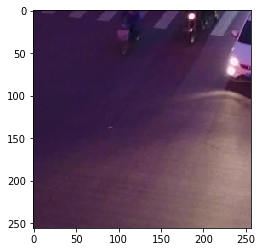

has_car_one_w_bbox (idx=0):


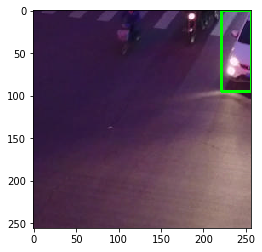

has car img (idx=1):


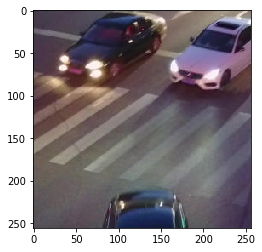

has_car_one_w_bbox (idx=1):


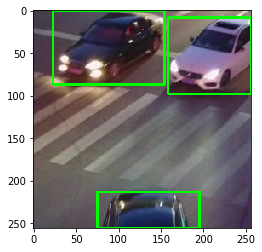

has car img (idx=2):


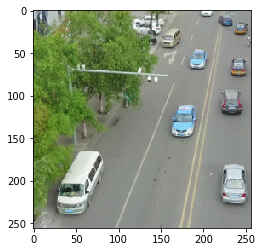

has_car_one_w_bbox (idx=2):


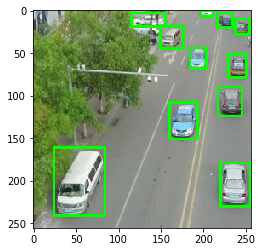

In [40]:
def test_print_bbox_on_idx(idx, has_car_imgs, bbox_df):
    has_car_one = has_car_imgs[idx]

    print("has car img (idx={}):".format(idx))
    plt.imshow(has_car_one)
    plt.show()

    has_car_one_w_bbox = has_car_one.copy()
    for bbox in bbox_df['bbox'][idx]:
        (l, t, r, b) = bbox
        has_car_one_w_bbox = cv2.rectangle(has_car_one_w_bbox, (l, t), (r, b), (0,255,0), 2)

    print("has_car_one_w_bbox (idx={}):".format(idx))
    plt.imshow(has_car_one_w_bbox)
    plt.show()
    
for i in range(3):
    test_print_bbox_on_idx(i, has_car_imgs, bbox_df)